# 라이브러리 불러오기

In [ ]:
!pip install pingouin
!pip install scikit_posthocs
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install haversine

In [ ]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy import stats # 통계 분석/검정용
import pingouin as pg # SciPy 통계함수보다 더 많은 정보를 간단한 함수 호출로 반환
import warnings # 경고 메시지 관리용
import scikit_posthocs as sp # 사후 다중 비교 검정용
import re

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick # 축 눈금(tick) 관련 기능 설정
plt.rcParams['axes.unicode_minus'] = False # 그래프에 마이너스(‘−’) 기호가 깨지는 현상을 방지
# plt.rcParams['figure.figsize'] = (12, 6) # 그래프의 기본 크기를 가로 12인치, 세로 6인치로 일괄 지정 (필요시)

# 출력 설정
warnings.filterwarnings('ignore') # 경고메시지 출력 안 함
pd.set_option('display.max_columns', None) # 데이터프레임을 출력할 때 모든 열(column)을 표시
pd.set_option('display.max_rows', 100) # 데이터프레임을 출력할 때 최대 100행까지만 표시하도록 제한

# 한글 폰트 설정
import platform
if platform.system() == 'Windows': # Windows OS
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # mac OS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 시드 설정
np.random.seed(42) # 팀원간의 결과물이 동일하게 보일 수 있게 (논의 필요)

# 위도 경도 거리 계산
from haversine import haversine, Unit

print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


# 데이터 불러오기

In [ ]:
# 데이터 로드
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_sellers = pd.read_csv("olist_sellers_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")
df_order_items = pd.read_csv("olist_order_items_dataset.csv")
df_order_payments = pd.read_csv("olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv")
df_product_translate = pd.read_csv("product_category_name_translation.csv")

print("="*60)
print("데이터 로드 완료!")
print("="*60)

# 데이터 행과 열 개수
print(f"\ndf_orders: {df_orders.shape}")
print(f"df_customers: {df_customers.shape}")
print(f"df_sellers: {df_sellers.shape}")
print(f"df_products: {df_products.shape}")
print(f"df_order_items: {df_order_items.shape}")
print(f"df_order_payments: {df_order_payments.shape}")
print(f"df_order_reviews: {df_order_reviews.shape}")
print(f"df_geolocation: {df_geolocation.shape}")
print(f"df_product_translate: {df_product_translate.shape}")

데이터 로드 완료!

df_orders: (99441, 8)
df_customers: (99441, 5)
df_sellers: (3095, 4)
df_products: (32951, 9)
df_order_items: (112650, 7)
df_order_payments: (103886, 5)
df_order_reviews: (99224, 7)
df_geolocation: (1000163, 5)
df_product_translate: (71, 2)


# 데이터 스키마
- 8개 테이블 관계도
- 1개 테이블 제외 (product_category_name_translation (카테고리 이름 번역))
![image.png](attachment:image.png)

# 데이터셋 파악

- 출처: 브라질 최대 이커머스 기업인 Olist에서 제공
  - 올리스트(Olist)
    - 브라질 전역의 소규모 사업체를 단일 계약으로 간편하게 여러 채널에 연결하는 기업
    - 판매자는 올리스트 매장을 통해 제품을 판매하고 올리스트 물류 파트너를 통해 고객에게 직접 배송할 수 있음
- 구성: 2016년부터 2018년까지 브라질 여러 마켓플레이스에서 발생한 10만 건의 주문 정보를 담고 있는 kaggle 데이터 (9개의 CSV 파일)
- 내용: 주문 상태, 가격, 결제 및 운송 실적부터 고객 위치, 제품 속성, 그리고 고객이 작성한 리뷰까지 다양한 측면에서 주문을 확인할 수 있음
- 특이사항: 브라질 우편번호와 위도/경도 좌표를 연결하는 위치 정보 데이터도 포함


# 테이블별 정보

- olist_orders_dataset (주문) (99,441개) * 핵심 데이터셋 (주문별 각종 정보를 찾을 수 있음)
  - 각 주문에서 다른 모든 정보를 찾을 수 있음 (주문/배송완료/배송예상시간 등)
  - 컬럼명 뜻
    * order_id: 주문 고유 ID
    * customer_id: 고객 고유 ID
    * order_status: 주문 상태
    * order_purchase_timestamp: 주문 구매 시각
    * order_approved_at: 주문 승인 시각
    * order_delivered_carrier_date: 물류 파트너에게 주문이 전달된 시각
    * order_delivered_customer_date: 고객에게 주문이 배송 완료된 시각
    * order_estimated_delivery_date: 고객에게 안내된 예상 배송일

- olist_customers_dataset (고객) (99,441개)
  - 고객과 고객 위치에 대한 정보 (주문 고유 고객 식별, 주문 배송 위치 등)
  - 각 주문에 고유한 customer_id가 할당됨 (동일한 고객이라도 주문마다 다른 ID를 받게 됨)
  - customer_unique_id를 사용하는 목적은 매장에서 재구매한 고객을 식별하기 위한 것 (중복 고객 구분하기 위함)
  - 컬럼명 뜻
    * customer_id: 고객 고유 ID (주문마다의 고객 ID로 중복이 없으며 기본키 역할을 함)
    * customer_unique_id: 고객의 고유 식별자 (한 고객이 여러 번 주문할 때 동일한 ID가 여러 번 나올 수 있음)
    * customer_zip_code_prefix: 고객 우편번호 앞부분
    * customer_city: 고객 거주 도시
    * customer_state: 고객 거주 주 또는 광역자치단체

- olist_sellers_dataset (판매자) (3,095개)
  - Olist에서 주문을 처리한 판매자의 위치 정보 (물류/배송, 세금 처리 등에서 중요)
  - 판매자 위치를 찾고 각 제품을 처리한 판매자를 식별할 수 있음
  - 컬럼명 뜻
    * seller_id: 판매자 고유 ID (상품을 판매하는 판매자 식별자)
    * seller_zip_code_prefix: 판매자 우편번호 앞부분
    * seller_city: 판매자 소재 도시 (611개)
    * seller_state: 판매자 소재 주 또는 광역자치단체 (23개)
      * 'seller_state' 세부내용 - 브라질의 행정구역(26개 주, 1개 연방구)
        * SP: 상파울루주 (São Paulo)
        * RJ: 리우데자네이루주 (Rio de Janeiro)
        * PE: 페르남부쿠주 (Pernambuco)
        * PR: 파라나주 (Paraná)
        * GO: 고이아스주 (Goiás)
        * SC: 산타카타리나주 (Santa Catarina)
        * BA: 바이아주 (Bahia)
        * DF: 연방구 (Distrito Federal, 브라질리아)
        * RS: 히우그란지두술주 (Rio Grande do Sul)
        * MG: 미나스제라이스주 (Minas Gerais)
        * RN: 히우그란지두노르치주 (Rio Grande do Norte)
        * MT: 마투그로수주 (Mato Grosso)
        * CE: 세아라주 (Ceará)
        * PB: 파라이바주 (Paraíba)
        * AC: 아크리주 (Acre)
        * ES: 이스피리투산투주 (Espírito Santo)
        * RO: 혼도니아주 (Rondônia)
        * PI: 피아우이주 (Piauí)
        * MS: 마투그로수두술주 (Mato Grosso do Sul)
        * SE: 세르지피주 (Sergipe)
        * MA: 마라냥주 (Maranhão)
        * AM: 아마조나스주 (Amazonas)
        * PA: 파라주 (Pará)

- olist_products_dataset (제품) (32,951개)
  - Olist에서 판매한 제품에 대한 데이터
  - 컬럼명 뜻
    * product_id: 제품 고유 ID
    * product_category_name: 제품 카테고리 이름
    * product_name_lenght: 제품 이름 길이
    * product_description_lenght: 제품 설명 길이
    * product_photos_qty: 제품 사진 수
    * product_weight_g: 제품 무게 (그램 단위)
    * product_length_cm: 제품 길이 (센티미터 단위)
    * product_height_cm: 제품 높이 (센티미터 단위)
    * product_width_cm: 제품 너비 (센티미터 단위)

- olist_order_items_dataset (주문 항목) (112,650개)
  - 각 주문 내에서 구매된 품목에 대한 데이터 (주문 상품, 판매자, 배송, 비용 등)
  - 예: order_id = 00143d0f86d6fbd9f9b38ab440ac16f53개의 품목(동일 제품)이 있음. 각 품목의 치수와 무게에 따라 운임 계산 (각 주문의 총 운임 금액 = 제품 + 운송료)
    - 총 order_item(제품) 값: 21.33 * 3 = 63.99
    - 총 운임 가치: 15.10 * 3 = 45.30
    - 총 주문 가치(제품 + 운송료): 63.99 + 45.30 = 109.29
  - 컬럼명 뜻
    * order_id: 주문 고유 ID  (각 주문을 구별하는 고유 번호)
    * order_item_id: 주문 상품 번호 (특정 주문 내에서 상품별 식별 번호)
    * product_id: 주문에 포함된 상품 ID들 (여러 상품이 포함될 수 있음)
    * seller_id: 판매자 고유 ID (상품을 판매하는 판매자 식별자)
    * shipping_limit_date: 배송 마감일 (해당 주문이 배송되어야 하는 최종 날짜)
    * price: 상품 가격
      - 화폐 단위는 브라질 공식 화폐 단위 헤알(BRL, Brazilian Real)로 추정 10헤알 = 약 2달러(USD)
    * freight_value: 배송비

- olist_order_payments_dataset (결제) (103,886개)
  - 주문 결제 옵션에 대한 데이터 (하나의 주문에 여러 결제 수단이 있을 수 있음)
  - 컬럼명 뜻
    * order_id: 주문 고유 번호
    * payment_sequential: 한 주문 내 여러 결제 수단이 있을 때, 결제 수단의 순서
    * payment_type: 결제 방식 종류 (예: 신용카드, 보레토 등)
      * 보레토: 브라질에서 많이 사용하는 결제 방식으로, 결제 코드가 포함된 종이나 PDF 형태의 전표. 이 전표를 은행, 복권 가게, 은행 앱을 통해 결제할 수 있음. 온라인 구매나 공과금 납부 등에 주로 쓰이며, 신용카드의 대안으로 많이 활용됨. 은행 계좌가 없는 사람도 이용 가능하도록 고안된 결제 방식
    * payment_installments: 할부 개월 수
    * payment_value: 결제 금액
      - 화폐 단위는 브라질 공식 화폐 단위 헤알(BRL, Brazilian Real)로 추정 10헤알 = 약 2달러(USD)
    
- olist_order_reviews_dataset (리뷰) (99,224개)
  - 고객이 작성한 리뷰에 대한 데이터 (평점, 후기 등)
  - 고객이 Olist Store에서 제품을 구매하면 판매자에게 주문 처리 알림이 전송됨
  - 고객이 제품을 수령하거나 예상 배송일이 다가오면, 이메일로 만족도 설문조사가 발송됨
  - 설문조사에 참여하면 구매 경험에 대한 메모를 남기고 의견을 남길 수 있음
  - 컬럼명 뜻
    * review_id: 리뷰 고유 ID (각 리뷰를 구별하는 고유 번호)
    * order_id: 주문 고유 ID (해당 리뷰에 연결된 주문 번호)
    * review_score: 리뷰 점수 (구매자가 매긴 평가 점수, 1~5점)
    * review_comment_title: 리뷰 제목 (리뷰의 제목)
    * review_comment_message: 리뷰 상세 내용 (구매자가 작성한 구체적인 후기)
    * review_creation_date: 리뷰 작성일자 (리뷰가 작성된 날짜와 시간)
    * review_answer_timestamp: 리뷰 답변 시각 (판매자 혹은 플랫폼에서 리뷰에 답변한 날짜와 시간)

- olist_geolocation_dataset (지리적 위치) (1,000,163개)
  - 브라질 우편번호와 위도/경도 좌표 정보
  - 고객 또는 상품의 위치를 파악하여 지역 맞춤형 서비스, 배송 최적화, 지역별 마케팅 등에 활용 가능
  - 지도 그려서 판매자와 고객 간의 거리 계산 가능
  - 컬럼명 뜻
    * geolocation_zip_code_prefix: 지리적 위치의 우편번호 앞부분 (일부 국가에서는 우편번호의 처음 부분만 저장)
    * geolocation_lat: 위도 (지리적 위치의 위도 좌표)
    * geolocation_lng: 경도 (지리적 위치의 경도 좌표)
    * geolocation_city: 시/도 이름 (도시 또는 지역명)
    * geolocation_state: 주 또는 광역지역 이름 (행정 구역명)

- product_category_name_translation (카테고리 이름 번역) (71개)
  - 제품 카테고리(포르투갈어)를 영어로 번역한 데이터
  - 제품을 쉽게 탐색하고 찾을 수 있도록 도와주며, 마케팅과 검색 최적화에도 활용 가능
  - 컬럼명 뜻
    * product_category_name: 제품 카테고리 이름 (포르투갈어)
    * product_category_name_english: 제품 카테고리 이름 (영어)
      - 상세 제품명 뜻은 팀 figma 참조


# EDA & 데이터 전처리 (Data Preprocessing)

## 중복 데이터 처리

In [ ]:
# 중복 데이터 확인
print(f"df_orders: {df_orders.duplicated().sum():,}건")
print(f"df_customers: {df_customers.duplicated().sum():,}건")
print(f"df_sellers: {df_sellers.duplicated().sum():,}건")
print(f"df_products: {df_products.duplicated().sum():,}건")
print(f"df_order_items: {df_order_items.duplicated().sum():,}건")
print(f"df_order_payments: {df_order_payments.duplicated().sum():,}건")
print(f"df_order_reviews: {df_order_reviews.duplicated().sum():,}건")
print(f"df_geolocation: {df_geolocation.duplicated().sum():,}건")
print(f"df_product_translate: {df_product_translate.duplicated().sum():,}건")

# 중복에 해당하는 행만 확인
df_geolocation[df_geolocation.duplicated]

df_orders: 0건
df_customers: 0건
df_sellers: 0건
df_products: 0건
df_order_items: 0건
df_order_payments: 0건
df_order_reviews: 0건
df_geolocation: 261,831건
df_product_translate: 0건


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
15,1046,-23.546081,-46.644820,sao paulo,SP
44,1046,-23.546081,-46.644820,sao paulo,SP
65,1046,-23.546081,-46.644820,sao paulo,SP
66,1009,-23.546935,-46.636588,sao paulo,SP
67,1046,-23.546081,-46.644820,sao paulo,SP
...,...,...,...,...,...
1000153,99970,-28.343273,-51.873734,ciriaco,RS
1000154,99950,-28.070493,-52.011342,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS


In [ ]:
# geo 데이터 중 261,831개(26%) 중복 제거
df_geolocation_clean = df_geolocation.drop_duplicates()
df_geolocation_clean

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000155,99965,-28.180655,-52.034367,agua santa,RS
1000156,99950,-28.072188,-52.011272,tapejara,RS
1000157,99950,-28.068864,-52.012964,tapejara,RS
1000158,99950,-28.068639,-52.010705,tapejara,RS


## 결측치 확인

In [ ]:
# 결측치 개수 확인
print(f"df_orders: {df_orders.isnull().sum().sum():,}건")
print(f"df_customers: {df_customers.isnull().sum().sum():,}건")
print(f"df_sellers: {df_sellers.isnull().sum().sum():,}건")
print(f"df_products: {df_products.isnull().sum().sum():,}건")
print(f"df_order_items: {df_order_items.isnull().sum().sum():,}건")
print(f"df_order_payments: {df_order_payments.isnull().sum().sum():,}건")
print(f"df_order_reviews: {df_order_reviews.isnull().sum().sum():,}건")
print(f"df_geolocation: {df_geolocation.isnull().sum().sum():,}건")
print(f"df_product_translate: {df_product_translate.isnull().sum().sum():,}건")

df_orders: 4,908건
df_customers: 0건
df_sellers: 0건
df_products: 2,448건
df_order_items: 0건
df_order_payments: 0건
df_order_reviews: 145,903건
df_geolocation: 0건
df_product_translate: 0건


### 결측치 있는 테이블 세부내용 확인

#### 주문 테이블 결측치 처리

In [ ]:
# 결측치 발생 컬럼 확인
df_orders.isnull().sum()


,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965
order_estimated_delivery_date,0


In [ ]:
# 결측치 모두 삭제
df_orders_clean = df_orders.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date'])
df_orders_clean.isnull().sum()

,0
order_id,0
customer_id,0
order_status,0
order_purchase_timestamp,0
order_approved_at,0
order_delivered_carrier_date,0
order_delivered_customer_date,0
order_estimated_delivery_date,0


In [ ]:
# 처리 전후 개수 비교
print(df_orders.shape)
print(df_orders_clean.shape)

(99441, 8)
(96461, 8)


#### 제품 테이블 결측치 처리

In [ ]:
# 결측치 발생 컬럼 확인
df_products.isnull().sum()

,0
product_id,0
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


In [ ]:
# 결측치 모두 삭제
df_products_clean = df_products.dropna()
df_products_clean.isnull().sum()

,0
product_id,0
product_category_name,0
product_name_lenght,0
product_description_lenght,0
product_photos_qty,0
product_weight_g,0
product_length_cm,0
product_height_cm,0
product_width_cm,0


In [ ]:
# 처리 전후 개수 비교
print(df_products.shape)
print(df_products_clean.shape)

(32951, 9)
(32340, 9)


#### 리뷰 테이블 결측치 처리

In [ ]:
# 결측치 발생 컬럼 확인
df_order_reviews.isnull().sum()

,0
review_id,0
order_id,0
review_score,0
review_comment_title,87656
review_comment_message,58247
review_creation_date,0
review_answer_timestamp,0


In [ ]:
# 결측치 포함된 텍스트 리뷰 컬럼(2열)만 삭제
df_order_reviews_clean = df_order_reviews.drop(columns=['review_comment_title', 'review_comment_message'])
df_order_reviews_clean.isnull().sum()

,0
review_id,0
order_id,0
review_score,0
review_creation_date,0
review_answer_timestamp,0


In [ ]:
# 처리 전후 개수 비교
print(df_order_reviews.shape)
print(df_order_reviews_clean.shape)

(99224, 7)
(99224, 5)


- 텍스트 리뷰(review_comment_title, review_comment_message) 분석 시, 정확한 결과를 위해 결측치가 포함된 데이터(행)은 모두 삭제 후 진행

## 기술통계 확인

In [ ]:
display(df_orders_clean.describe(include='all').T)
display(df_customers.describe(include='all').T)
display(df_sellers.describe(include='all').T)
display(df_products_clean.describe(include='all').T)
display(df_order_items.describe(include='all').T)
display(df_order_payments.describe(include='all').T)
display(df_order_reviews_clean.describe(include='all').T)
display(df_geolocation.describe(include='all').T)
display(df_product_translate.describe(include='all').T)

# display: 통계 정보를 시각적으로 보기 좋게 출력
# describe(include='all'): 모든 열(숫자/문자/범주형 등 포함)에 대해 각 열의 기초 통계 요약 정보 확인
# T: 컬럼별 통계치를 한 줄씩 보기 쉽게 전치(Transpose) = 행과 열을 뒤집어 각 열이 한 행(row)씩 되도록 정렬
# top:  해당 열에서 가장 많이 나온 값(최빈값, mode)
# freq: 그 최빈값이 데이터에 등장한 횟수

,count,unique,top,freq
order_id,96461,96461,66dea50a8b16d9b4dee7af250b4be1a5,1
customer_id,96461,96461,edb027a75a1449115f6b43211ae02a24,1
order_status,96461,2,delivered,96455
order_purchase_timestamp,96461,95939,2017-11-20 11:46:30,3
order_approved_at,96461,88272,2018-02-27 04:31:10,9
order_delivered_carrier_date,96461,80100,2018-05-09 15:48:00,47
order_delivered_customer_date,96461,95649,2018-05-08 19:36:48,3
order_estimated_delivery_date,96461,445,2017-12-20 00:00:00,507


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,99441,99441,274fa6071e5e17fe303b9748641082c8,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_unique_id,99441,96096,8d50f5eadf50201ccdcedfb9e2ac8455,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_zip_code_prefix,99441.0,NaN,NaN,NaN,35137.474583,29797.938996,1003.0,11347.0,24416.0,58900.0,99990.0
customer_city,99441,4119,sao paulo,15540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_state,99441,27,SP,41746,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
seller_id,3095,3095,9e25199f6ef7e7c347120ff175652c3b,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_zip_code_prefix,3095.0,NaN,NaN,NaN,32291.059451,32713.45383,1001.0,7093.5,14940.0,64552.5,99730.0
seller_city,3095,611,sao paulo,694,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_state,3095,23,SP,1849,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_id,32340,32340,106392145fca363410d287a815be6de4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category_name,32340,73,cama_mesa_banho,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name_lenght,32340.0,NaN,NaN,NaN,48.476592,10.245699,5.0,42.0,51.0,57.0,76.0
product_description_lenght,32340.0,NaN,NaN,NaN,771.492393,635.124831,4.0,339.0,595.0,972.0,3992.0
product_photos_qty,32340.0,NaN,NaN,NaN,2.188961,1.736787,1.0,1.0,1.0,3.0,20.0
product_weight_g,32340.0,NaN,NaN,NaN,2276.956586,4279.291845,0.0,300.0,700.0,1900.0,40425.0
product_length_cm,32340.0,NaN,NaN,NaN,30.854545,16.955965,7.0,18.0,25.0,38.0,105.0
product_height_cm,32340.0,NaN,NaN,NaN,16.958813,13.636115,2.0,8.0,13.0,21.0,105.0
product_width_cm,32340.0,NaN,NaN,NaN,23.208596,12.078762,6.0,15.0,20.0,30.0,118.0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,112650,98666,8272b63d03f5f79c56e9e4120aec44ef,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_item_id,112650.0,NaN,NaN,NaN,1.197834,0.705124,1.0,1.0,1.0,1.0,21.0
product_id,112650,32951,aca2eb7d00ea1a7b8ebd4e68314663af,527,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller_id,112650,3095,6560211a19b47992c3666cc44a7e94c0,2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shipping_limit_date,112650,93318,2017-07-21 18:25:23,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,112650.0,NaN,NaN,NaN,120.653739,183.633928,0.85,39.9,74.99,134.9,6735.0
freight_value,112650.0,NaN,NaN,NaN,19.99032,15.806405,0.0,13.08,16.26,21.15,409.68


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
order_id,103886,99440,fa65dad1b0e818e3ccc5cb0e39231352,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_sequential,103886.0,NaN,NaN,NaN,1.092679,0.706584,1.0,1.0,1.0,1.0,29.0
payment_type,103886,5,credit_card,76795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
payment_installments,103886.0,NaN,NaN,NaN,2.853349,2.687051,0.0,1.0,1.0,4.0,24.0
payment_value,103886.0,NaN,NaN,NaN,154.10038,217.494064,0.0,56.79,100.0,171.8375,13664.08


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
review_id,99224,98410,4548534449b1f572e357211b90724f1b,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_id,99224,98673,03c939fd7fd3b38f8485a0f95798f1f6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_score,99224.0,NaN,NaN,NaN,4.086421,1.347579,1.0,4.0,5.0,5.0,5.0
review_creation_date,99224,636,2017-12-19 00:00:00,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_answer_timestamp,99224,98248,2017-06-15 23:21:05,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
geolocation_zip_code_prefix,1000163.0,NaN,NaN,NaN,36574.166466,30549.33571,1001.0,11075.0,26530.0,63504.0,99990.0
geolocation_lat,1000163.0,NaN,NaN,NaN,-21.176153,5.715866,-36.605374,-23.603546,-22.919377,-19.97962,45.065933
geolocation_lng,1000163.0,NaN,NaN,NaN,-46.390541,4.269748,-101.466766,-48.573172,-46.637879,-43.767709,121.105394
geolocation_city,1000163,8011,sao paulo,135800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
geolocation_state,1000163,27,SP,404268,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count,unique,top,freq
product_category_name,71,71,beleza_saude,1
product_category_name_english,71,71,health_beauty,1


## 이상치 처리

In [ ]:
# 결제 테이블의 결제 금액(payment_value) 최소값(0) 이상치 의심 -> 데이터 오류나 비정상 거래 가능성
print(f"결제 금액 범위: {df_order_payments['payment_value'].min():.2f} ~ {df_order_payments['payment_value'].max():.2f}")

결제 금액 범위: 0.00 ~ 13664.08


In [ ]:
# 해당 데이터 삭제
df_order_payments_clean = df_order_payments[df_order_payments['payment_value'] != 0.0]
df_order_payments_clean.describe()

,payment_sequential,payment_installments,payment_value
count,103877.000000,103877.000000,103877.000000
mean,1.092340,2.853509,154.113732
std,0.704312,2.687112,217.498755
min,1.000000,0.000000,0.010000
25%,1.000000,1.000000,56.820000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.840000
max,29.000000,24.000000,13664.080000


In [ ]:
# 처리 전후 개수 비교
print(df_order_payments.shape)
print(df_order_payments_clean.shape)

(103886, 5)
(103877, 5)


## 전처리 후 데이터 개수

In [ ]:
print(f"df_orders: {df_orders_clean.shape}")
print(f"df_customers: {df_customers.shape}")
print(f"df_sellers: {df_sellers.shape}")
print(f"df_products: {df_products_clean.shape}")
print(f"df_order_items: {df_order_items.shape}")
print(f"df_order_payments: {df_order_payments_clean.shape}")
print(f"df_order_reviews: {df_order_reviews_clean.shape}")
print(f"df_geolocation: {df_geolocation_clean.shape}")
print(f"df_product_translate: {df_product_translate.shape}")

df_orders: (96461, 8)
df_customers: (99441, 5)
df_sellers: (3095, 4)
df_products: (32340, 9)
df_order_items: (112650, 7)
df_order_payments: (103877, 5)
df_order_reviews: (99224, 5)
df_geolocation: (738332, 5)
df_product_translate: (71, 2)


## 테이블 정보 확인

In [ ]:
# 모든 테이블 정보
print(df_orders_clean.info())
print(df_customers.info())
print(df_sellers.info())
print(df_products_clean.info())
print(df_order_items.info())
print(df_order_payments_clean.info())
print(df_order_reviews_clean.info())
print(df_geolocation_clean.info())
print(df_product_translate.info())

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96461 non-null  object
 1   customer_id                    96461 non-null  object
 2   order_status                   96461 non-null  object
 3   order_purchase_timestamp       96461 non-null  object
 4   order_approved_at              96461 non-null  object
 5   order_delivered_carrier_date   96461 non-null  object
 6   order_delivered_customer_date  96461 non-null  object
 7   order_estimated_delivery_date  96461 non-null  object
dtypes: object(8)
memory usage: 6.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null 

## 테이블 세부 내용 확인

In [ ]:
df_orders_clean

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [ ]:
df_customers

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
...,...,...,...,...,...
99436,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,sao paulo,SP
99437,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,taboao da serra,SP
99438,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fortaleza,CE
99439,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,canoas,RS


In [ ]:
df_sellers

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
...,...,...,...,...
3090,98dddbc4601dd4443ca174359b237166,87111,sarandi,PR
3091,f8201cab383e484733266d1906e2fdfa,88137,palhoca,SC
3092,74871d19219c7d518d0090283e03c137,4650,sao paulo,SP
3093,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS


In [ ]:
# 판매자 소재 도시 고유값 확인
df_sellers['seller_city'].unique()

array(['campinas', 'mogi guacu', 'rio de janeiro', 'sao paulo',
       'braganca paulista', 'brejao', 'penapolis', 'curitiba', 'anapolis',
       'itirapina', 'tubarao', 'lauro de freitas', 'imbituba', 'brasilia',
       'porto seguro', 'guaruja', 'tabatinga', 'salto', 'tres de maio',
       'belo horizonte', 'arapongas', 'sao bernardo do campo', 'tatui',
       'garopaba', 'camanducaia', 'tupa', 'guarulhos',
       'sao jose dos pinhais', 'sao ludgero', 'sao jose', 'piracicaba',
       'porto alegre', 'congonhal', 'santo andre', 'osasco', 'valinhos',
       'joinville', 'saquarema', 'barra velha', 'petropolis',
       'santo antonio da patrulha', 'ponta grossa', 'santana de parnaiba',
       'sao carlos', 'ibitinga', 'barueri', 'caxias do sul', 'araguari',
       'contagem', 'jaragua do sul', 'lages - sc', 'bento goncalves',
       'catanduva', 'ribeirao pires', 'jaboticabal', 'echapora', 'cotia',
       'rio do sul', 'sorocaba', 'pradopolis', 'itaborai', 'mirassol',
       'birigui',

In [ ]:
# 판매자 소재 도시 개수 확인 (611개)
len(df_sellers['seller_city'].unique())

611

In [ ]:
# 판매자 소재 행정구역(주 또는 광역자치단체) 고유값 확인
df_sellers['seller_state'].unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'AC', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM',
       'PA'], dtype=object)

In [ ]:
# 판매자 소재 도시 개수 확인 (23개)
# 브라질의 행정구역 (26개 주, 1개 연방구)
len(df_sellers['seller_state'].unique())

23

In [ ]:
df_sellers['seller_state'].unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'AC', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM',
       'PA'], dtype=object)

In [ ]:
df_products_clean

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [ ]:
df_order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [ ]:
df_order_payments_clean

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
...,...,...,...,...,...
103881,0406037ad97740d563a178ecc7a2075c,1,boleto,1,363.31
103882,7b905861d7c825891d6347454ea7863f,1,credit_card,2,96.80
103883,32609bbb3dd69b3c066a6860554a77bf,1,credit_card,1,47.77
103884,b8b61059626efa996a60be9bb9320e10,1,credit_card,5,369.54


In [ ]:
df_order_reviews_clean

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,2018-07-01 00:00:00,2018-07-02 12:59:13


In [ ]:
df_geolocation_clean

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000155,99965,-28.180655,-52.034367,agua santa,RS
1000156,99950,-28.072188,-52.011272,tapejara,RS
1000157,99950,-28.068864,-52.012964,tapejara,RS
1000158,99950,-28.068639,-52.010705,tapejara,RS


In [ ]:
df_product_translate

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


## 날짜 데이터 처리

### 데이터 타입 변환 (object -> datetime)

In [ ]:
# 특정 컬럼들을 날짜 타입으로 변환 함수
def to_date(data ,column_list):
    for column in column_list:
        data[column] = pd.to_datetime(data[column])
    return data

# 두 날짜 간 일수 계산 함수
def date_diff(start_date, end_date):
    date_diff = pd.to_datetime(end_date) - pd.to_datetime(start_date)
    return date_diff.days

In [ ]:
# 날짜 데이터 타입 변환 (object -> datetime)
date_column_list = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
olist_orders_dataset = to_date(df_orders_clean, date_column_list)

## 시각화

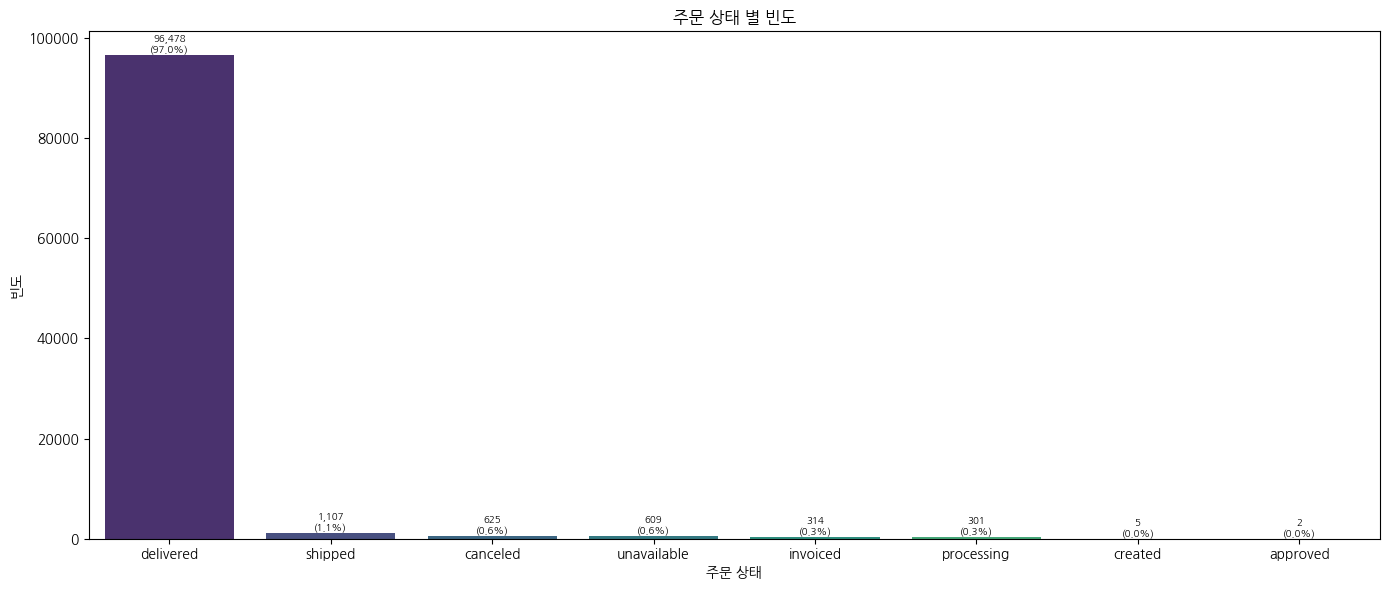

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=df_orders,
    x='order_status',
    palette='viridis',
    order=df_orders['order_status'].value_counts().index
)

# 전체 데이터 개수
total = len(df_orders)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                   # y 위치 (막대 꼭대기)
        f'{count:,}\n({percentage})',     # 표시할 텍스트
        ha='center',                       # 수평 정렬
        va='bottom',                       # 수직 정렬
        fontsize=7
    )

plt.title("주문 상태 별 빈도")
plt.xlabel("주문 상태")
plt.ylabel("빈도")
plt.tight_layout()

plt.show()

In [ ]:
orders_dataset_datetime = df_orders.copy()
orders_dataset_datetime['order_purchase_timestamp'] = pd.to_datetime(orders_dataset_datetime['order_purchase_timestamp'], errors='coerce')
# 연월 컬럼 생성
orders_dataset_datetime['year_month'] = orders_dataset_datetime['order_purchase_timestamp'].dt.to_period("M")
# 요일 컬럼 생성
orders_dataset_datetime['Day_of_Week'] = orders_dataset_datetime['order_purchase_timestamp'].dt.strftime('%a')
# 시간대 컬럼 생성
orders_dataset_datetime['Hour_of_Day'] = orders_dataset_datetime['order_purchase_timestamp'].dt.hour
def convert_hour_to_time(hour):
  if hour >=0 and hour < 6:
    return '심야/새벽'
  if hour >= 6 and hour < 12:
    return '오전'
  if hour >= 12 and hour < 18:
    return '오후'
  if hour >= 18 and hour < 24:
    return '저녁'
orders_dataset_datetime['Time_of_Day'] = orders_dataset_datetime['Hour_of_Day'].apply(convert_hour_to_time)

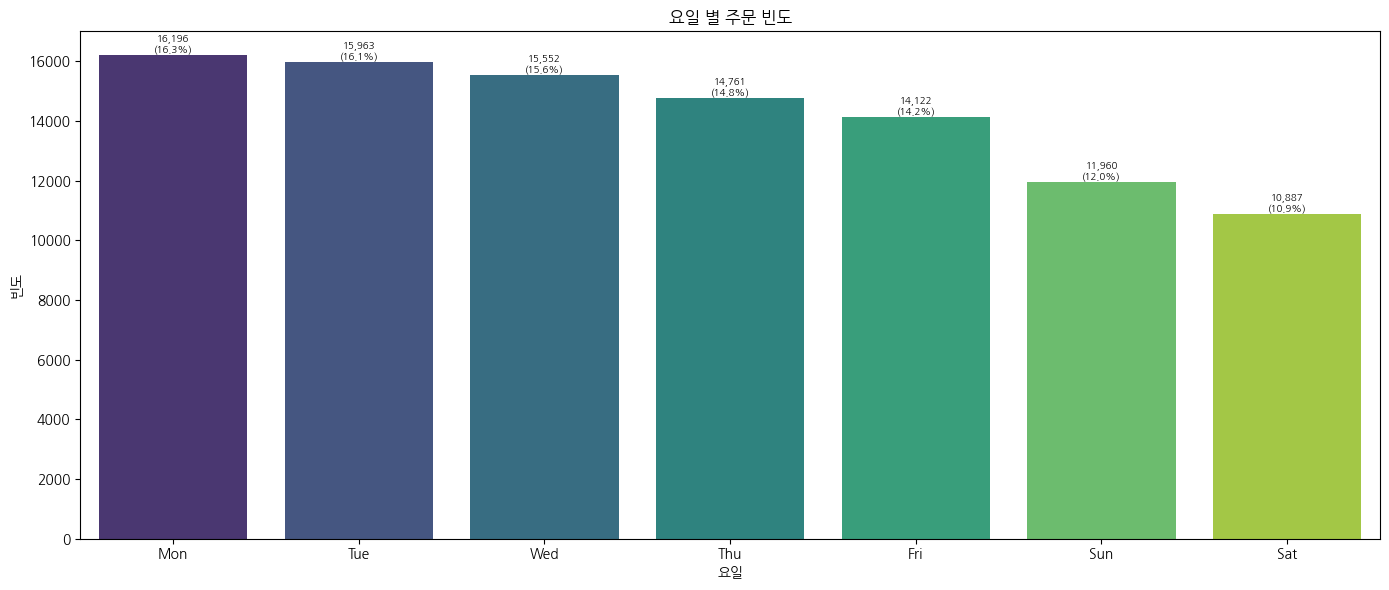

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=orders_dataset_datetime,
    x='Day_of_Week',
    palette='viridis',
    order=orders_dataset_datetime['Day_of_Week'].value_counts().index
)

# 전체 데이터 개수
total = len(orders_dataset_datetime)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                   # y 위치 (막대 꼭대기)
        f'{count:,}\n({percentage})',     # 표시할 텍스트
        ha='center',                       # 수평 정렬
        va='bottom',                       # 수직 정렬
        fontsize=7
    )

plt.title("요일 별 주문 빈도")
plt.xlabel("요일")
plt.ylabel("빈도")
plt.tight_layout()

plt.show()

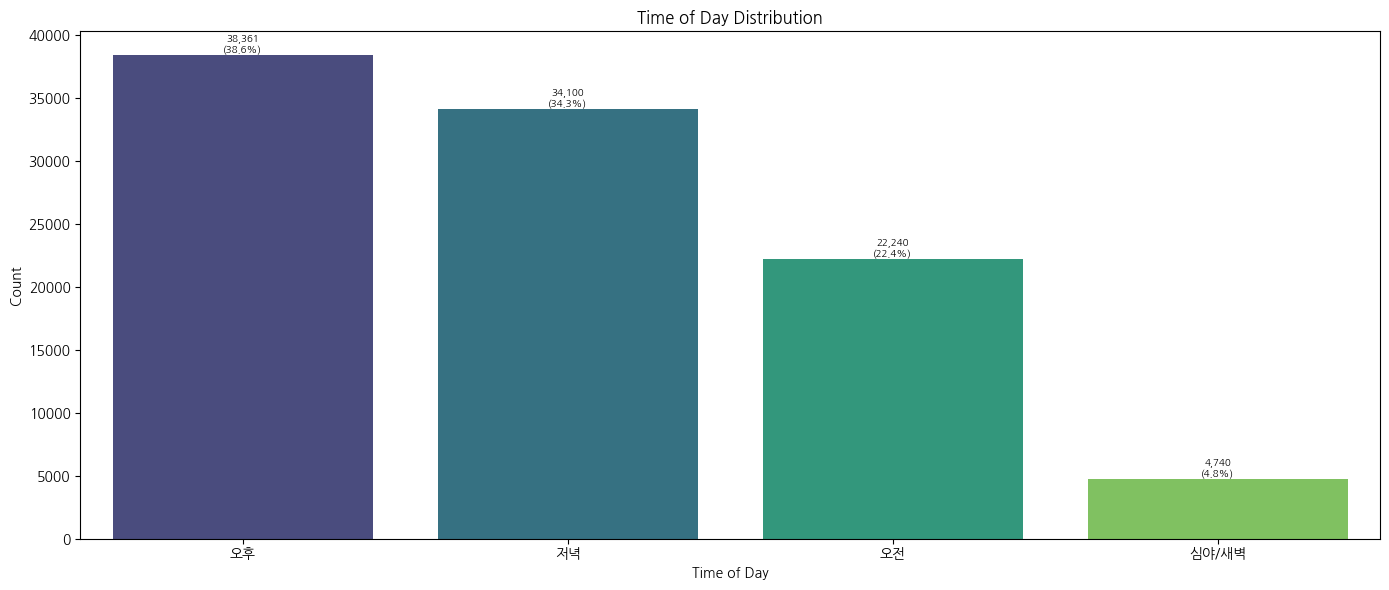

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=orders_dataset_datetime,
    x='Time_of_Day',
    palette='viridis',
    order=orders_dataset_datetime['Time_of_Day'].value_counts().index
)

# 전체 데이터 개수
total = len(orders_dataset_datetime)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                   # y 위치 (막대 꼭대기)
        f'{count:,}\n({percentage})',     # 표시할 텍스트
        ha='center',                       # 수평 정렬
        va='bottom',                       # 수직 정렬
        fontsize=7
    )

plt.title("Time of Day Distribution")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.tight_layout()

plt.show()

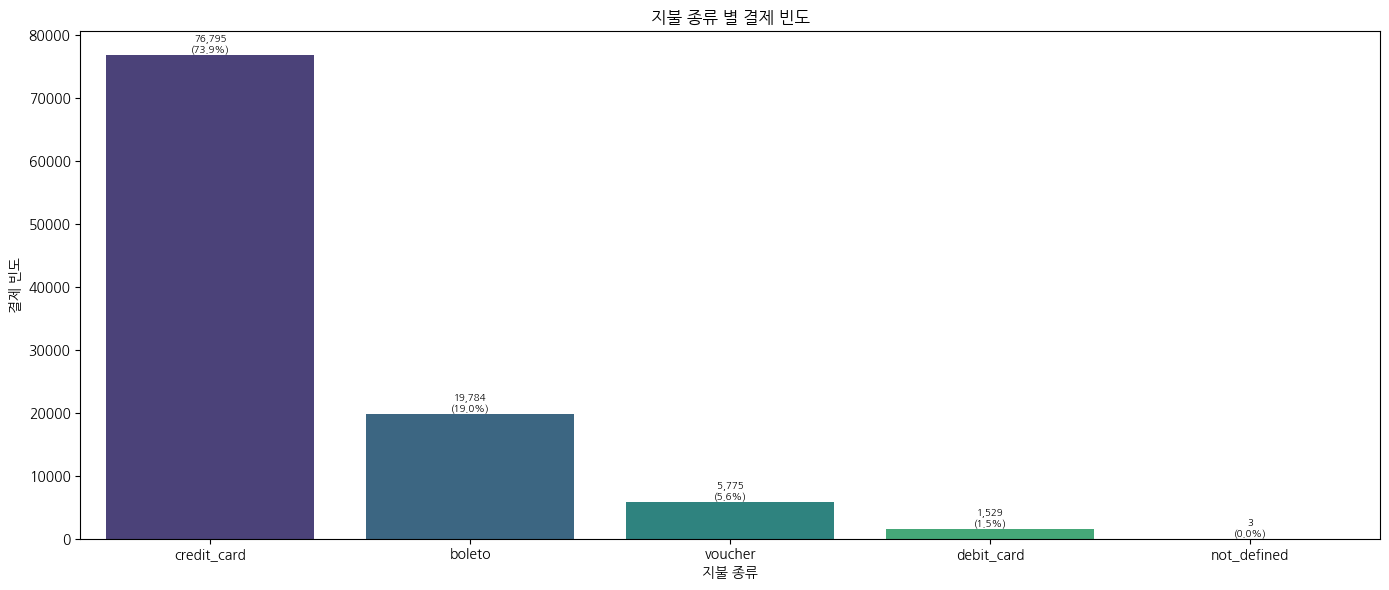

In [ ]:
# 지불 타입

plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=df_order_payments,
    x='payment_type',
    palette='viridis',
    order=df_order_payments['payment_type'].value_counts().index
)

# 전체 데이터 개수
total = len(df_order_payments)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                   # y 위치 (막대 꼭대기)
        f'{count:,}\n({percentage})',     # 표시할 텍스트
        ha='center',                       # 수평 정렬
        va='bottom',                       # 수직 정렬
        fontsize=7
    )

plt.title("지불 종류 별 결제 빈도")
plt.xlabel("지불 종류")
plt.ylabel("결제 빈도")
plt.tight_layout()

plt.show()

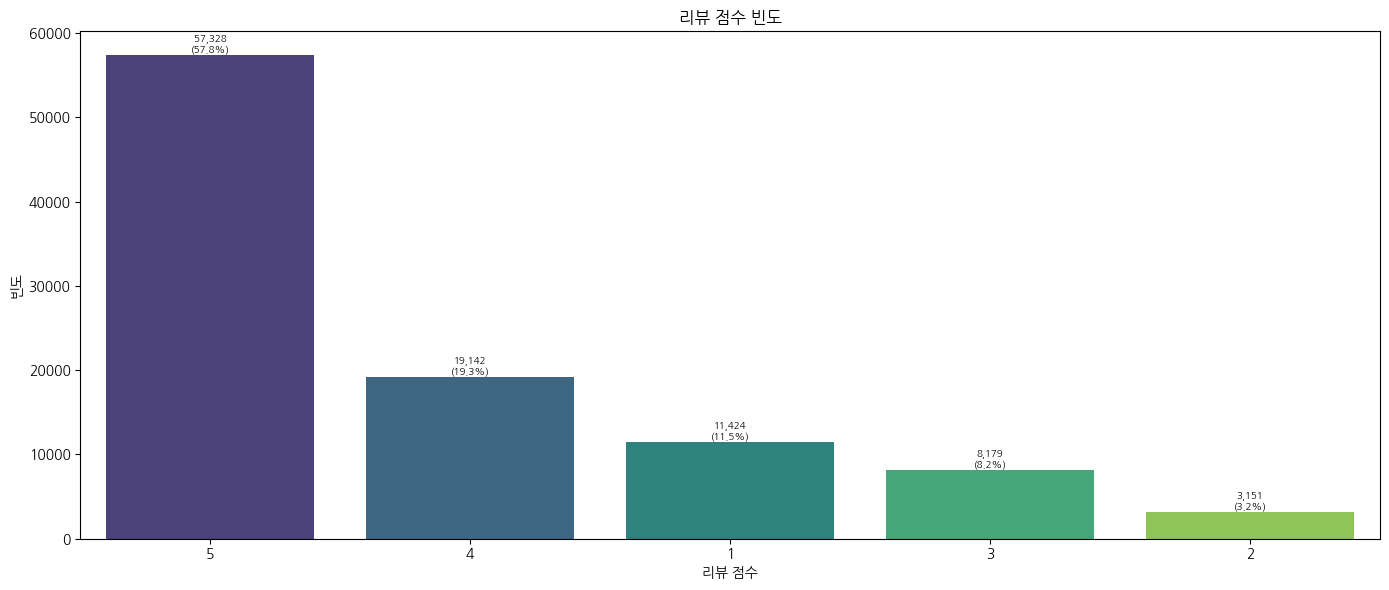

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(
    data=df_order_reviews,
    x='review_score',
    palette='viridis',
    order=df_order_reviews['review_score'].value_counts().index
)

# 전체 데이터 개수
total = len(df_order_reviews)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    count = int(p.get_height())
    percentage = f'{100 * count / total:.1f}%'
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                   # y 위치 (막대 꼭대기)
        f'{count:,}\n({percentage})',     # 표시할 텍스트
        ha='center',                       # 수평 정렬
        va='bottom',                       # 수직 정렬
        fontsize=7
    )

plt.title("리뷰 점수 빈도")
plt.xlabel("리뷰 점수")
plt.ylabel("빈도")
plt.tight_layout()

plt.show()

In [ ]:
# 주 별 평균 결제 금액 확인을 위한 데이터셋 결합
customers_orders = pd.merge(df_customers, df_orders, on = 'customer_id', how='inner')
customers_orders_items = pd.merge(customers_orders, df_order_items, on = 'order_id', how='inner')

In [ ]:
# 주 별 평균 결제 금액
state_price_avg = customers_orders_items.groupby(['customer_state'])['price'].mean().reset_index(name='avg_price').sort_values(by='avg_price', ascending=False)

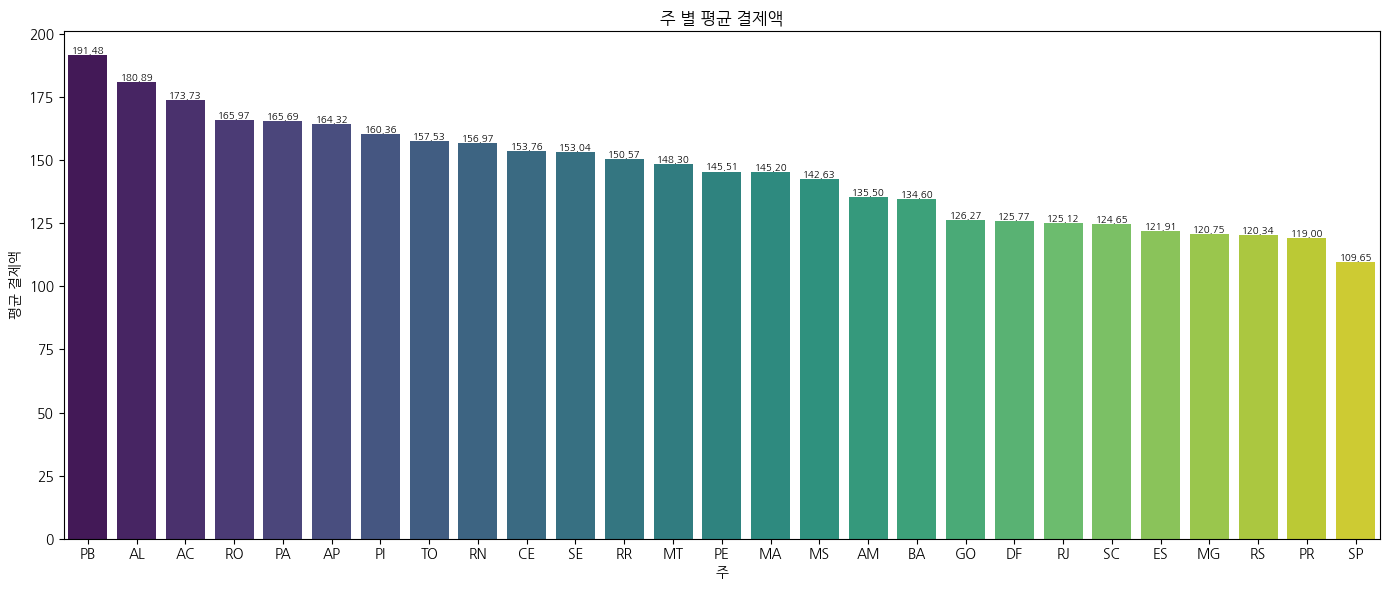

In [ ]:
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data = state_price_avg,
    x = 'customer_state',
    y = 'avg_price',
    palette = 'viridis',
)

# 전체 데이터 개수
total = len(state_price_avg)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    avg_price = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                  # y 위치 (막대 꼭대기)
        f'{avg_price:.2f}',          # 평균 가격 표시
        ha='center',                     # 수평 정렬
        va='bottom',                     # 수직 정렬
        fontsize=7
    )

plt.title("주 별 평균 결제액")
plt.xlabel("주")
plt.ylabel("평균 결제액")
plt.tight_layout()
plt.show()

In [ ]:
# 주 별 전체 결제 금액
state_price_sum = customers_orders_items.groupby(['customer_state'])['price'].sum().reset_index(name='sum_price').sort_values(by='sum_price', ascending=False)

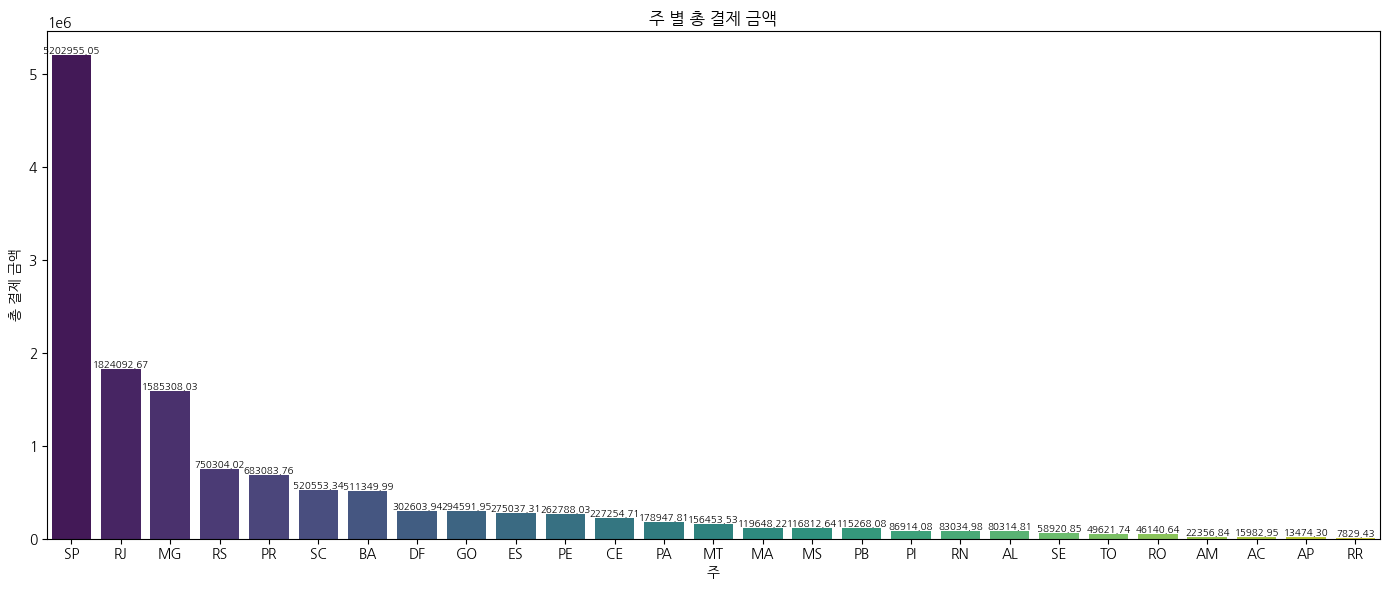

In [ ]:
plt.figure(figsize=(14, 6))

ax = sns.barplot(
    data = state_price_sum,
    x = 'customer_state',
    y = 'sum_price',
    palette = 'viridis',
)

# 전체 데이터 개수
total = len(state_price_sum)

# 각 막대 위에 개수와 비율 표시
for p in ax.patches:
    sum_price = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # x 위치 (막대 중앙)
        p.get_height(),                  # y 위치 (막대 꼭대기)
        f'{sum_price:.2f}',          # 총 가격 표시
        ha='center',                     # 수평 정렬
        va='bottom',                     # 수직 정렬
        fontsize=7
    )

plt.title("주 별 총 결제 금액")
plt.xlabel("주")
plt.ylabel("총 결제 금액")
plt.tight_layout()
plt.show()

# 통계 분석

## 배송과 만족도의 상관관계

- 먼저 리뷰점수를 고객 만족도의 지표로 삼아 배송 기간에 따라 고객 만족도의 차이가 있는지 확인하였습니다.
- 배송이 부정적 만족도를 유도한다면, 늦은 배송이 낮은 만족도를 유도할 것이라 예상할 수 있기 때문입니다.
- 따라서 주문 데이터 셋과 리뷰 데이터 셋 중 어떤 데이터도 누락되면 안되기 때문에 이너 조인을 통해 테이블을 결합하여 상관관계를 계산하였습니다.

### 주문 데이터 처리

In [ ]:
# 주문일자와 예상 배송일자 차이 (예상 배송일수)
df_orders_clean['estimated_dt'] = df_orders_clean.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_estimated_delivery_date']
    ),
    axis=1 # 행 단위 적용 (필수)
)

# 주문일자와 실제 배송일자 차이 (실제 배송일수)
df_orders_clean['real_dt'] = df_orders_clean.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_customer_date']
    ),
    axis=1 # 행 단위 적용 (필수)
)

# 판매자에게 주문이 전달된 일자와 주문 일자의 차이
df_orders_clean['seller_dt'] = df_orders_clean.apply(
    lambda row: date_diff(
        row['order_purchase_timestamp'],
        row['order_delivered_carrier_date']
    ),
    axis=1  # 행 단위 적용 (필수)
)

In [ ]:
# 주문 테이블에 예상 배송 일수와 실제 배송 일수 간의 차이 컬럼(est_dlv_diff) 생성
df_orders_clean['est_dlv_diff'] = df_orders_clean['estimated_dt'] - df_orders_clean['real_dt']
df_orders_clean

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_dt,real_dt,seller_dt,est_dlv_diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,15,8,2,7
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,19,13,1,6
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,26,9,0,17
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,26,13,3,13
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,12,2,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,18,8,1,10
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,23,22,1,1
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,30,24,1,6
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,37,17,3,20


### 리뷰 데이터 처리

In [ ]:
# 주문 ID와 리뷰 평점만 남겨 새로운 데이터 프레임 생성 (조인 후 보기 편하게)
df_order_reviews_new = df_order_reviews_clean[['order_id', 'review_score']]
df_order_reviews_new

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5
...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,5
99220,22ec9f0669f784db00fa86d035cf8602,5
99221,55d4004744368f5571d1f590031933e4,5
99222,7725825d039fc1f0ceb7635e3f7d9206,4


### 고객 데이터 처리

In [ ]:
# 고객 ID와 고객 거주 지역(State)만 남겨 새로운 데이터 프레임 생성 (조인 후 보기 편하게)
df_customers = df_customers[['customer_id', 'customer_state']]

### 주문-리뷰 데이터 테이블 결합

In [ ]:
df_dt_reviews_join = pd.merge(df_orders_clean, df_order_reviews_new, on='order_id', how='inner')
df_dt_reviews_join

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_dt,real_dt,seller_dt,est_dlv_diff,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,15,8,2,7,4
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,19,13,1,6,4
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,26,9,0,17,5
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,26,13,3,13,5
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,12,2,0,10,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96339,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,18,8,1,10,5
96340,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,23,22,1,1,4
96341,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,30,24,1,6,5
96342,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,37,17,3,20,2


### 배송기간에 따른 만족도 변화 시각화

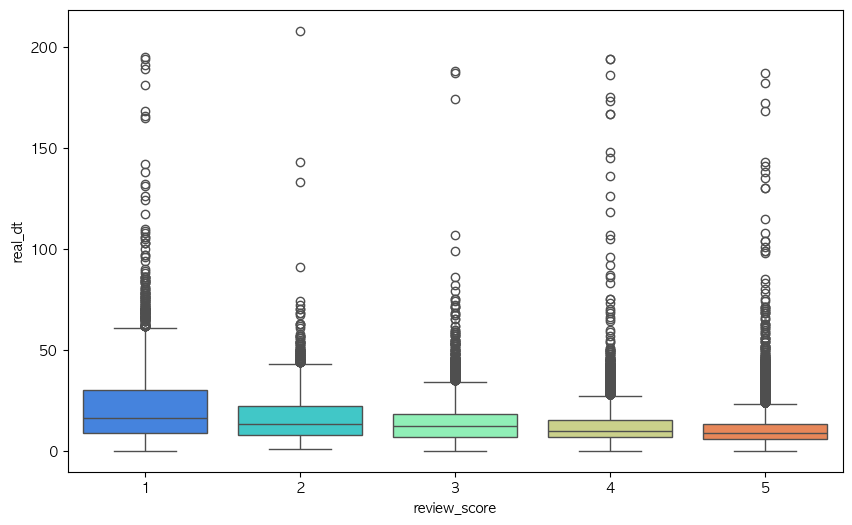

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_dt_reviews_join, x='review_score', y='real_dt', palette='rainbow')
plt.show()

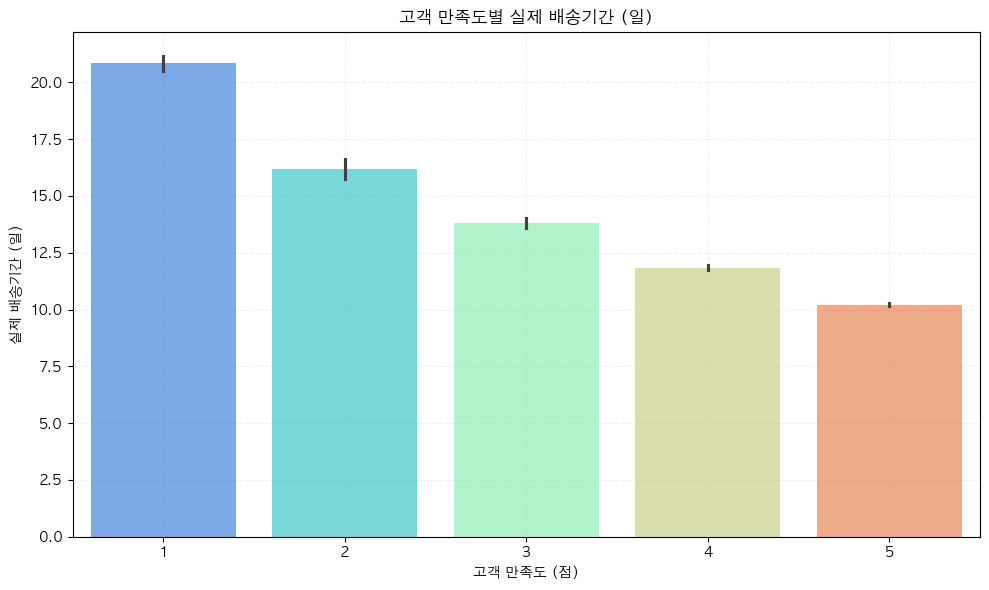

In [ ]:
# 고객 만족도별 실제 배송기간
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dt_reviews_join, x='review_score', y='real_dt', palette='rainbow', alpha=0.7)
plt.title('고객 만족도별 실제 배송기간')
plt.xlabel('고객 만족도 (점)')
plt.ylabel('실제 배송기간 (일)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

- 시각적으로 확인하면 리뷰 점수가 낮은 집단에서 평균 배송 기간이 길어지는 것을 확인할 수 있습니다.
- 일종의 선형적 관계가 있다고도 볼 수 있습니다.
- 이를 정확하게 확인하기 위해 통계적 분석을 시행하여 통계적 차이가 있는지 확인하였습니다.

## 통계 검정 1

In [ ]:
# 정규성 검정 함수
def shapiro_stat(df, label_column, target_column):
    labels = df[label_column].unique()
    p_results = []
    result = ''
    for label in labels:
        stat, p = stats.shapiro(df[df[label_column] == label][target_column])
        p_results.append(p)

    if all(p > 0.05 for p in p_results):
        result = '모든 집단의 분포가 정규 분포임'
    else:
        result = '정규 분포가 아닌 집단이 존재함'

    print(f"""
    ==================================
    정규성 검정 결과
    ==================================
    {result}
    ==================================
    """)


# 등분산성 검정 함수
def levene_stat(df, label_column, target_column):
    labels = df[label_column].unique()
    df_split = []
    result = ''
    for label in labels:
        df_split.append(df[df[label_column] == label][target_column])
    stat, p = stats.levene(*df_split)

    if p < 0.05:
        result = '귀무가설을 기각'
    else:
        result = '귀무가설을 기각하지 않음'

    print(f"""
    ==================================
    등분산 검정 결과
    ==================================
    p-value: {p:.3f}
    ==================================
    {result}
    ==================================
    """)


# 비모수 검정 함수 (Kruskal-Wallis)
def kruskal_test(data, target_column, label_column):
    labels = data[label_column].unique()
    data_list = []
    for label in labels:
        data_list.append(data[data[label_column] == label][target_column])
    stat, p_value = stats.kruskal(*data_list)

    print(f"""
    ==================================
    Kruskal-Wallis 결과
    ==================================
    p-value: {p_value:.3f}
    ==================================
    {('검정 결과가 통계적으로 유의함' if p_value < 0.05 else '검정 결과가 통계적으로 유의하지 않음')}
    ==================================
    """)

# 사후검정 (Kruskal-Wallis에서 유의미한 그룹 차이가 확인되면, 어떤 그룹 간에 차이가 나는지 추가로 비교)
    print("==================================")
    print("사후검정")
    print("==================================")
    dunn_result = sp.posthoc_dunn(data, val_col=target_column,
                                 group_col=label_column, p_adjust='bonferroni')

    for index, row in dunn_result.iterrows():
        print(f"==================================\n{index}와 다른 항목")
        for i, p in enumerate(row):
            if p < 0.05:
                print(f"{i+1} p-value: {p:.3f}", end=', ')
        print()  # 줄 바꿈


In [ ]:
# 정규성/등분산성/비모수 검정
shapiro_stat(df_dt_reviews_join, 'review_score', 'real_dt')
levene_stat(df_dt_reviews_join, 'review_score', 'real_dt')
kruskal_test(df_dt_reviews_join, 'real_dt', 'review_score')


    정규성 검정 결과
    정규 분포가 아닌 집단이 존재함
    

    등분산 검정 결과
    p-value: 0.000
    귀무가설을 기각
    

    Kruskal-Wallis 결과
    p-value: 0.000
    검정 결과가 통계적으로 유의함
    
사후검정
1와 다른 항목
2 p-value: 0.000, 3 p-value: 0.000, 4 p-value: 0.000, 5 p-value: 0.000, 
2와 다른 항목
1 p-value: 0.000, 3 p-value: 0.000, 4 p-value: 0.000, 5 p-value: 0.000, 
3와 다른 항목
1 p-value: 0.000, 2 p-value: 0.000, 4 p-value: 0.000, 5 p-value: 0.000, 
4와 다른 항목
1 p-value: 0.000, 2 p-value: 0.000, 3 p-value: 0.000, 5 p-value: 0.000, 
5와 다른 항목
1 p-value: 0.000, 2 p-value: 0.000, 3 p-value: 0.000, 4 p-value: 0.000, 


정규성과 등분산성 가정 모두 깨져서 비모수 검정(Kruskal-Wallis)과 사후검정을 진행한 결과,
- 리뷰 점수에 따라 배송 기간의 차이가 유의미하게 존재하고 있음을 확인하였습니다.
- 반대로 배송의 기간이 길어지더라도 좋은 리뷰를 준 경우도 존재하며,
- 배송 기간이 짧아져도 나쁜 리뷰 점수를 준 경우 역시 존재합니다.
- 따라서 부정적인 리뷰의 더 결정적인 이유가 존재하고 있을 것이라고 생각하였습니다.

# 우리의 가설: "현재 배송모델은 부정확하다"

estimated_dt    23.377948
real_dt         12.058447
dtype: float64


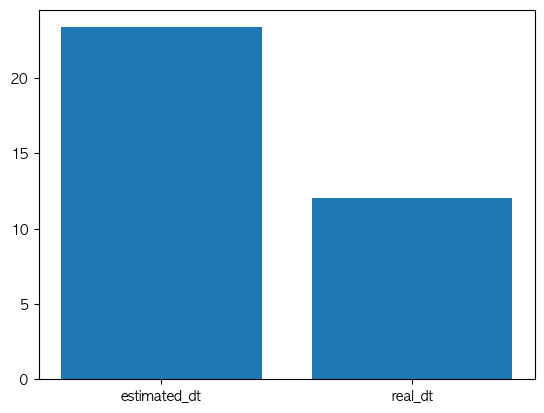

In [ ]:
# 예상/실제 배송일수 막대 그래프 비교
df_bar = df_dt_reviews_join[['estimated_dt', 'real_dt']].mean()
print(df_bar)
plt.bar(df_bar.index, df_bar.values)
plt.show()

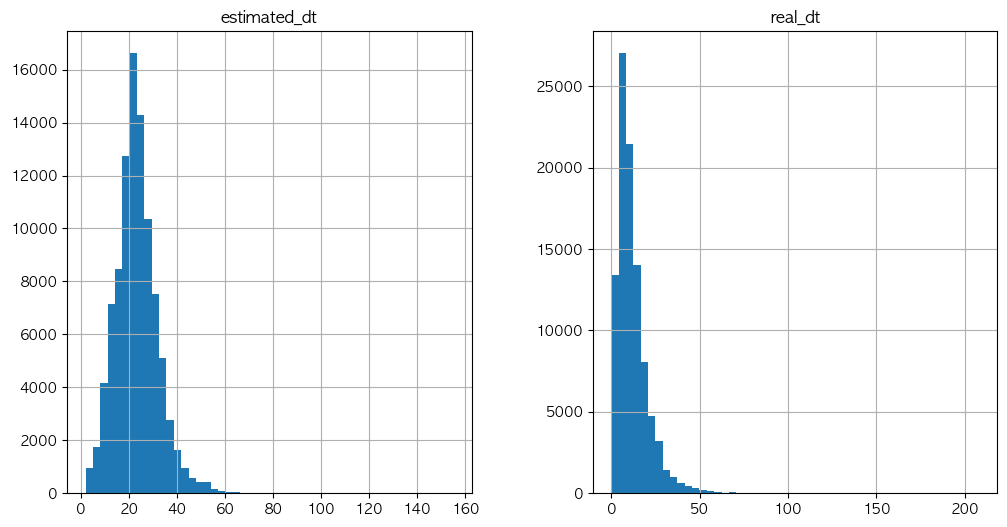

In [ ]:
# 예상/실제 배송일수 히스토그램 비교
df_dt_reviews_join[['estimated_dt', 'real_dt']].hist(bins = 50, figsize=(12, 6))
plt.show()

- 기존 배송 예측 모델은 평균 22일을 기준으로 정규 분포에 가까운 분포를 보이는 반면,
- 실제 배송 시간은 평균 9일로 왼쪽으로 치우처진 긴꼬리 분포의 모양을 보입니다.

In [ ]:
df_cleaned = df_dt_reviews_join[(df_dt_reviews_join['est_dlv_diff'].quantile(0.001) <= df_dt_reviews_join['est_dlv_diff']) & (df_dt_reviews_join['est_dlv_diff'] <= df_dt_reviews_join['est_dlv_diff'].quantile(0.999))]

11.37961980824026


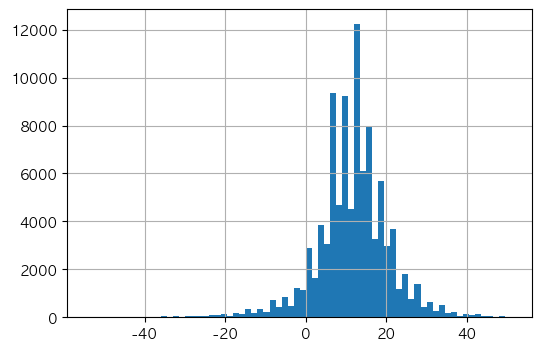

In [ ]:
# 예상 배송 일수와 실제 배송 일수 간의 차이 분포
print(df_cleaned['est_dlv_diff'].mean())
df_cleaned['est_dlv_diff'].hist(bins = 70, figsize=(6, 4))
plt.show()

11.319500954911566


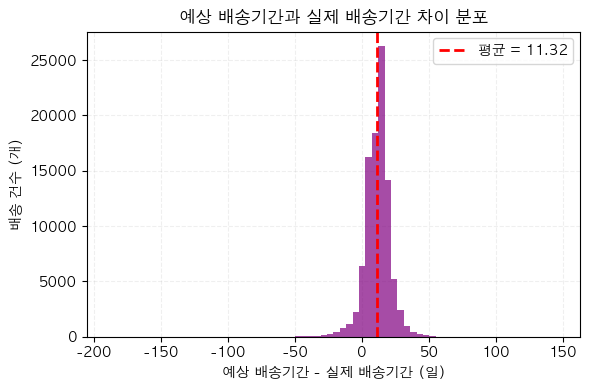

In [ ]:
# 예상 배송 일수와 실제 배송 일수 간의 차이 분포
print(df_dt_reviews_join['est_dlv_diff'].mean())
df_dt_reviews_join['est_dlv_diff'].hist(bins = 70, figsize=(6, 4), color = 'purple', alpha=0.7)
plt.title('예상 배송기간과 실제 배송기간 차이 분포')
plt.xlabel('예상 배송기간 - 실제 배송기간 (일)')
plt.ylabel('배송 건수 (개)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'평균 = {mean_val:.2f}') # 평균선 추가
plt.legend()
plt.show()

- 배송 예상 시간과 실제 배송시간의 차이는 12일 정도로 상당히 보수적으로 예측하고 있는 것을 확인 할 수 있습니다.
- 문제는 배송 예측이 상당히 보수적으로 이루어지고 있음에도, 배송 지연이 발생하는 경우가 있었다는 것입니다.
- 이는 배송 예측 모델이 정확하지 않다는 사실을 설명한다고도 말할 수 있습니다.

## 배송 예측의 부정확성으로 인한 배송 지연에 따른 불만족

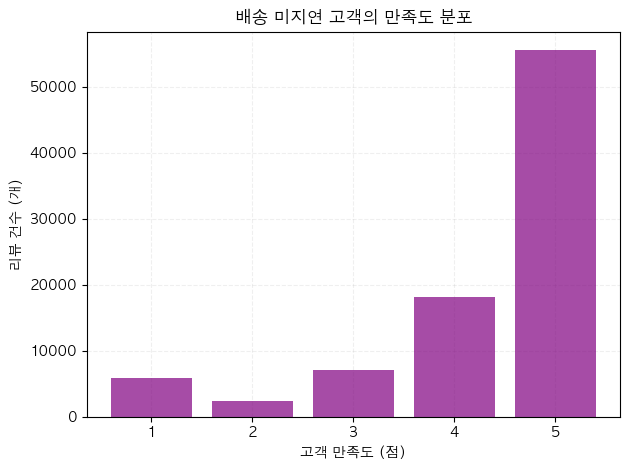

In [ ]:
# 배송 예측이 실제보다 늦거나 같은 경우 (배송기간 예측을 보수적으로 한 경우)
df_late_delivery = df_dt_reviews_join[df_dt_reviews_join['est_dlv_diff'] >= 0]
df_late_delivery_bar = df_late_delivery.groupby("review_score").size()
plt.bar(df_late_delivery_bar.index, df_late_delivery_bar.values, color = 'purple', alpha=0.7)
plt.title('배송 미지연 고객의 만족도 분포')
plt.xlabel('고객 만족도 (점)')
plt.ylabel('리뷰 건수 (개)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

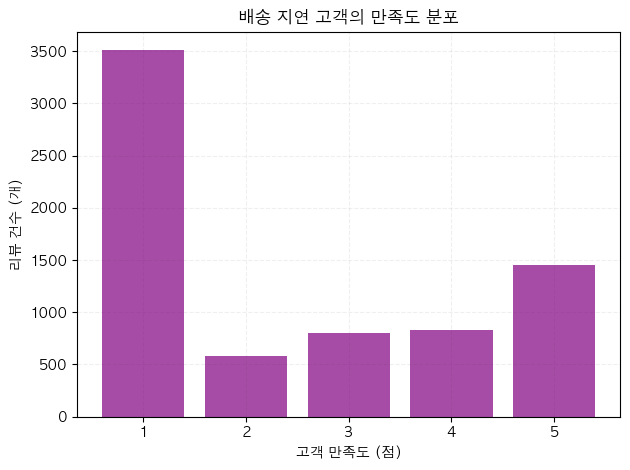

In [ ]:
# 배송기간 예측이 실제보다 빠른 경우 = 배송지연 (배송일수 예측을 실패한 경우)
df_late_delivery = df_dt_reviews_join[df_dt_reviews_join['est_dlv_diff'] < 0]
df_late_delivery_bar = df_late_delivery.groupby("review_score").size()
plt.bar(df_late_delivery_bar.index, df_late_delivery_bar.values, color = 'purple', alpha=0.7)
plt.title('배송 지연 고객의 만족도 분포')
plt.xlabel('고객 만족도 (점)')
plt.ylabel('리뷰 건수 (개)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

- 효과 크기는 약한 효과만 존재한다고 설명하지만, 시각화된 그래프에서 지연의 효과가 특히 1점 대에서 크게 나타나고 있음을 확인해주고 있습니다. 이는 배송 예측 시스템으로 인해 나타난 배송의 지연이 부정적 리뷰를 만들어 내는 원인이 될 수도 있다는 사실을 말해주고 있습니다.

## 통계 검정 2

In [ ]:
def chi_square_test(df, x_columns, y_columns):
  df_crosstab = pd.crosstab(df[x_columns], df[y_columns])
  chi2, pval, dof, expected = stats.chi2_contingency(df_crosstab)

  print(f"""
  ==================================
  Chi-squared 검정 결과
  ==================================
  p-value: {pval:2f}
  ==================================
  효과 크기: {
      np.sqrt(
          chi2 / (
              len(df) * min(
                  len(df[x_columns].unique())-1,
                  len(df[y_columns].unique())-1
                  )
              )
          )
      :2f}
  ========₩==========================
  {('검정 결과가 통계적으로 유의함'if pval < 0.05 else '검정 결과가 통계적으로 유의하지 않음')}
  ==================================
  """)

In [ ]:
# 배송일수를 지연/미지연으로 나눠 그룹화
df_dt_reviews_join['est_dlv_diff_group'] = 0 # 배송 지연 = 0
df_dt_reviews_join.loc[df_dt_reviews_join['est_dlv_diff'] >= 0, 'est_dlv_diff_group'] = 1 # 배송 미지연 = 1

In [ ]:
# 카이제곱 검정 (배송 예측 실패 여부 vs 리뷰 점수 교차표)
chi_square_test(df_dt_reviews_join, 'est_dlv_diff_group', 'review_score')


  Chi-squared 검정 결과
  p-value: 0.000000
  효과 크기: 0.396612
  ========₩==========================
  검정 결과가 통계적으로 유의함
  


- 효과 크기는 약한 효과만 존재한다고 설명하지만, 시각화된 그래프에서 지연의 효과가 특히 1점 대에서 크게 나타나고 있음을 확인해주고 있습니다.
- 이는 배송 예측 시스템으로 인해 나타난 배송 지연이 부정적 리뷰를 만들어 내는 원인이 될 수도 있다는 사실을 말해준다고 볼 수 있습니다.

## 배송 지연 정도에 따른 만족도 효과 확인

In [ ]:
# 배송 지연 그룹(0)의 만족도 확인을 위해 예상-실제 배송일수 차이 구간화
df_late = df_dt_reviews_join[df_dt_reviews_join['est_dlv_diff_group'] == 0].copy()
df_late['est_dlv_diff_group'] = pd.qcut(df_late['est_dlv_diff'], q=5, labels=['1','2','3','4','5'], duplicates='drop')
df_late['est_dlv_diff_group'].value_counts()

est_dlv_diff_group
4    1681
2    1641
1    1450
3    1276
5    1135
Name: count, dtype: int64

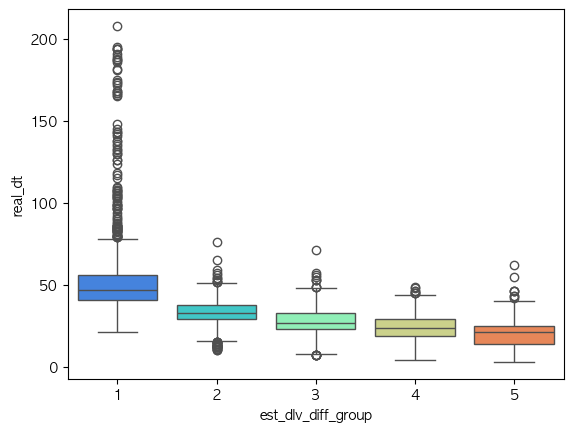

In [ ]:
sns.boxplot(data=df_late, x='est_dlv_diff_group', y='real_dt', palette='rainbow')
plt.show()

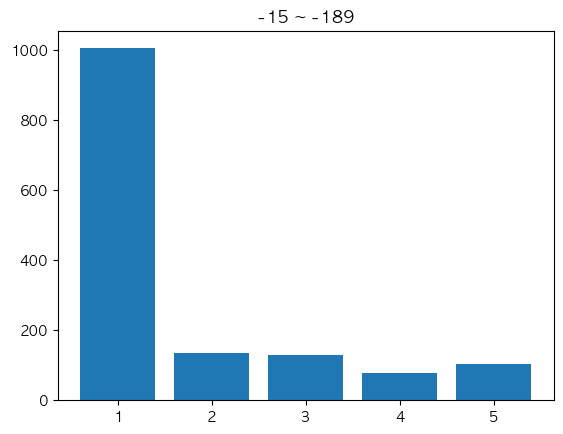

In [ ]:
df_1 = df_late[df_late['est_dlv_diff_group'] == '1']
df_1_bar = df_1.groupby("review_score").size()
plt.bar(df_1_bar.index, df_1_bar.values)
plt.title(f"{df_1['est_dlv_diff'].max()} ~ {df_1['est_dlv_diff'].min()}")
plt.show()

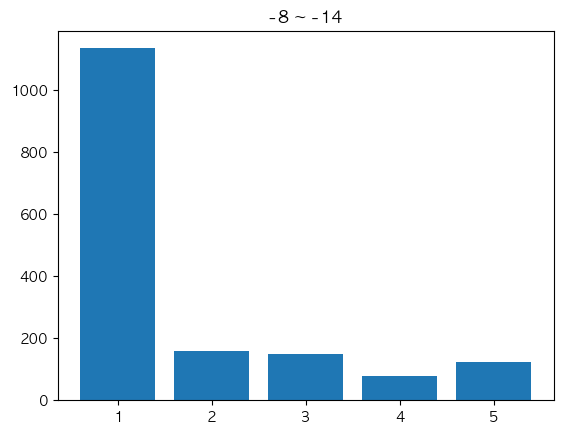

In [ ]:
df_2 = df_late[df_late['est_dlv_diff_group'] == '2']
df_2_bar = df_2.groupby("review_score").size()
plt.bar(df_2_bar.index, df_2_bar.values)
plt.title(f"{df_2['est_dlv_diff'].max()} ~ {df_2['est_dlv_diff'].min()}")
plt.show()

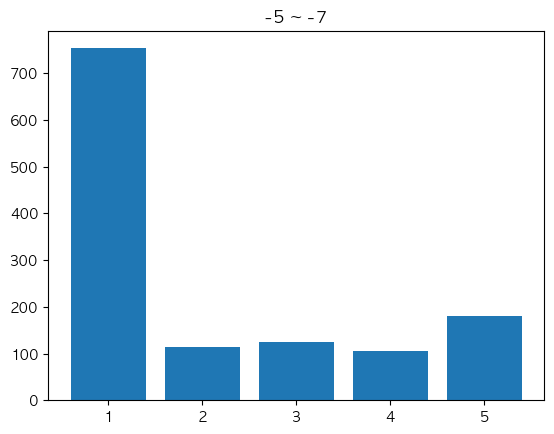

In [ ]:
df_3 = df_late[df_late['est_dlv_diff_group'] == '3']
df_3_bar = df_3.groupby("review_score").size()
plt.bar(df_3_bar.index, df_3_bar.values)
plt.title(f"{df_3['est_dlv_diff'].max()} ~ {df_3['est_dlv_diff'].min()}")
plt.show()

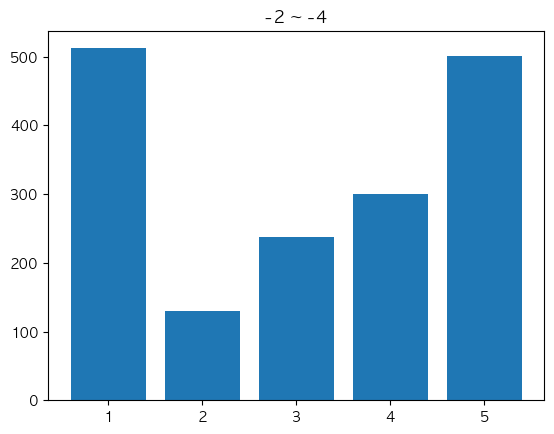

In [ ]:
df_4 = df_late[df_late['est_dlv_diff_group'] == '4']
df_4_bar = df_4.groupby("review_score").size()
plt.bar(df_4_bar.index, df_4_bar.values)
plt.title(f"{df_4['est_dlv_diff'].max()} ~ {df_4['est_dlv_diff'].min()}")
plt.show()

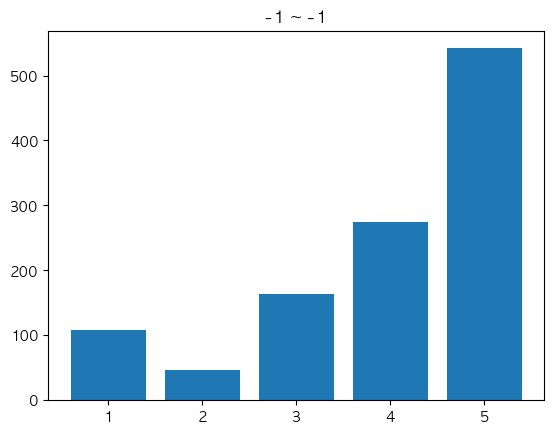

In [ ]:
df_5 = df_late[df_late['est_dlv_diff_group'] == '5']
df_5_bar = df_5.groupby("review_score").size()
plt.bar(df_5_bar.index, df_5_bar.values)
plt.title(f"{df_5['est_dlv_diff'].max()} ~ {df_5['est_dlv_diff'].min()}")
plt.show()

<BarContainer object of 5 artists>

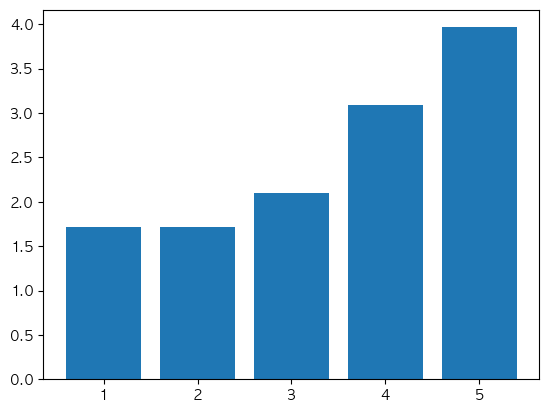

In [ ]:
plt.bar(
    df_late.groupby('est_dlv_diff_group')['review_score'].mean().index,
    df_late.groupby('est_dlv_diff_group')['review_score'].mean().values
    )

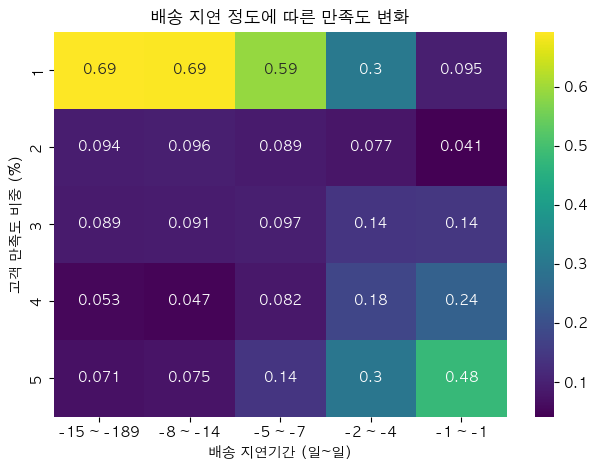

In [ ]:
# 히트맵으로 다시 그리기 (배송 지연 정도에 따른 리뷰 만족도 효과)
heat_df = pd.concat([
    df_1_bar / df_1_bar.sum(),
    df_2_bar / df_2_bar.sum(),
    df_3_bar / df_3_bar.sum(),
    df_4_bar / df_4_bar.sum(),
    df_5_bar / df_5_bar.sum()],
    axis=1
).rename(columns={
    0:f"{df_1['est_dlv_diff'].max()} ~ {df_1['est_dlv_diff'].min()}",
    1:f"{df_2['est_dlv_diff'].max()} ~ {df_2['est_dlv_diff'].min()}",
    2:f"{df_3['est_dlv_diff'].max()} ~ {df_3['est_dlv_diff'].min()}",
    3:f"{df_4['est_dlv_diff'].max()} ~ {df_4['est_dlv_diff'].min()}",
    4:f"{df_5['est_dlv_diff'].max()} ~ {df_5['est_dlv_diff'].min()}",
})
sns.heatmap(data=heat_df, annot=True, cmap="viridis")
plt.title('배송 지연 정도에 따른 만족도 변화')
plt.xlabel('배송 지연기간 (일~일)')
plt.ylabel('고객 만족도 비중 (%)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()

In [ ]:
chi_square_test(df_late, 'est_dlv_diff_group', 'review_score')


  Chi-squared 검정 결과
  p-value: 0.000000
  효과 크기: 0.260993
  ========₩==========================
  검정 결과가 통계적으로 유의함
  


- 배송 지연이 충분히 리뷰 만족도 저하에 효과가 있음을 확인하였다면, 이제 어느정도의 지연이 리뷰 만족도를 극도로 저하시키는지 확인해야 합니다.
- 데이터를 배송 지연 일수에 따라 5개의 집단으로 나누어 확인하였을 때, 지연 2일 째부터 리뷰만족도에 영향을 미치기 시작하며,
- 3일 이후 부터는 리뷰 만족도에서 1점 리뷰가 극도로 증가하는 모습을 관측할 수 있었습니다.
- 따라서 보수적인 리뷰를 가정한다면 가능한 배송 지연이 최대 2일로 한정되어야 합니다.

## 지역에 따른 배송 지연율

In [ ]:
# 고객 거주지역(State)
df_customers['customer_state'].unique()

array(['SP', 'SC', 'MG', 'PR', 'RJ', 'RS', 'PA', 'GO', 'ES', 'BA', 'MA',
       'MS', 'CE', 'DF', 'RN', 'PE', 'MT', 'AM', 'AP', 'AL', 'RO', 'PB',
       'TO', 'PI', 'AC', 'SE', 'RR'], dtype=object)

In [ ]:
# 고객 거주지역(State) 수
len(df_customers['customer_state'].unique())

27

### 주문-리뷰-고객 데이터 테이블 결합

In [ ]:
# 지연 배송일 계산 테이블과 고객 거주지역 테이블 조인
reviews_region_join = pd.merge(df_dt_reviews_join, df_customers, on='customer_id', how='inner')
reviews_region_join

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_dt,real_dt,seller_dt,est_dlv_diff,review_score,est_dlv_diff_group,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,15,8,2,7,4,1,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,19,13,1,6,4,1,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,26,9,0,17,5,1,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,26,13,3,13,5,1,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,12,2,0,10,5,1,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96339,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,18,8,1,10,5,1,SP
96340,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,23,22,1,1,4,1,SP
96341,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,30,24,1,6,5,1,BA
96342,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,37,17,3,20,2,1,RJ


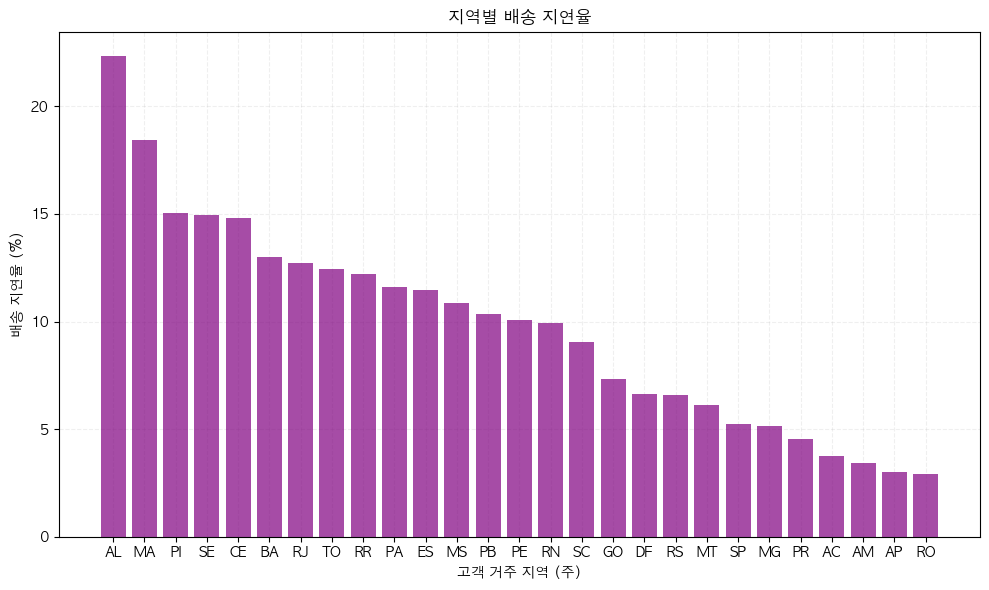

In [ ]:
# 고객 거주지역별(State) 배송 지연율(%)
df_bar = (
    reviews_region_join[reviews_region_join['est_dlv_diff_group']==0].
    groupby('customer_state').size()
    /
    reviews_region_join.
    groupby('customer_state').size()
    *
    100
    ).dropna().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_bar.index, df_bar.values, color = 'purple', alpha=0.7)
plt.title('지역별 배송 지연율')
plt.xlabel('고객 거주 지역 (주)')
plt.ylabel('배송 지연율 (%)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

- 배송지연율이 높은 지역은 동부에 위치한 AL(알라고아스 주)과 MA(마라냥 주)
- 배송지연율이 낮은 지역은 북부에 위치한 AP(아마파 주)와 RO(혼도니아 주)

## 고객 거주 지역(State)별 인구당 주문건수와 배송지연 간 상관관계

In [ ]:
# 브라질 주별 인구수 데이터 (2005년, 위키피디아) 불러오기

html_data = """<tbody>
<tr>
<td>AC</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Acre.svg" class="mw-file-description"><img alt="아크리주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Bandeira_do_Acre.svg/40px-Bandeira_do_Acre.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Bandeira_do_Acre.svg/60px-Bandeira_do_Acre.svg.png 2x" data-file-width="500" data-file-height="350"></a></span></span> <a href="/wiki/%EC%95%84%ED%81%AC%EB%A6%AC%EC%A3%BC" title="아크리주">아크리주</a></td>
<td>Acre</td>
<td><a href="/wiki/%ED%9E%88%EC%9A%B0%EB%B8%8C%EB%9E%91%EC%BF%A0" title="히우브랑쿠">히우브랑쿠</a></td>
<td>Rio Branco</td>
<td align="right">656,043</td>
<td align="right">152,581</td>
<td align="right">4.3
</td></tr><tr>
<td>AL</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Alagoas.svg" class="mw-file-description"><img alt="알라고아스주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/88/Bandeira_de_Alagoas.svg/40px-Bandeira_de_Alagoas.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/88/Bandeira_de_Alagoas.svg/60px-Bandeira_de_Alagoas.svg.png 2x" data-file-width="600" data-file-height="400"></a></span></span> <a href="/wiki/%EC%95%8C%EB%9D%BC%EA%B3%A0%EC%95%84%EC%8A%A4%EC%A3%BC" title="알라고아스주">알라고아스주</a></td>
<td>Alagoas</td>
<td><a href="/wiki/%EB%A7%88%EC%84%B8%EC%9D%B4%EC%98%A4" title="마세이오">마세이오</a></td>
<td>Maceió</td>
<td align="right">3,015,912</td>
<td align="right">27,767</td>
<td align="right">108.6
</td></tr><tr>
<td>AM</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Amazonas.svg" class="mw-file-description"><img alt="아마조나스주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Bandeira_do_Amazonas.svg/40px-Bandeira_do_Amazonas.svg.png" decoding="async" width="22" height="16" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Bandeira_do_Amazonas.svg/60px-Bandeira_do_Amazonas.svg.png 2x" data-file-width="700" data-file-height="500"></a></span></span> <a href="/wiki/%EC%95%84%EB%A7%88%EC%A1%B0%EB%82%98%EC%8A%A4%EC%A3%BC" title="아마조나스주">아마조나스주</a></td>
<td>Amazonas</td>
<td><a href="/wiki/%EB%A7%88%EB%82%98%EC%9A%B0%EC%8A%A4" title="마나우스">마나우스</a></td>
<td>Manaus</td>
<td align="right">3,232,330</td>
<td align="right">1,570,745</td>
<td align="right">2.1
</td></tr><tr>
<td>AP</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Amap%C3%A1.svg" class="mw-file-description"><img alt="아마파주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Bandeira_do_Amap%C3%A1.svg/40px-Bandeira_do_Amap%C3%A1.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/0c/Bandeira_do_Amap%C3%A1.svg/60px-Bandeira_do_Amap%C3%A1.svg.png 2x" data-file-width="1000" data-file-height="700"></a></span></span> <a href="/wiki/%EC%95%84%EB%A7%88%ED%8C%8C%EC%A3%BC" title="아마파주">아마파주</a></td>
<td>Amapá</td>
<td><a href="/wiki/%EB%A7%88%EC%B9%B4%ED%8C%8C" title="마카파">마카파</a></td>
<td>Macapá</td>
<td align="right">594,587</td>
<td align="right">142,814</td>
<td align="right">4.2
</td></tr><tr>
<td>BA</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_da_Bahia.svg" class="mw-file-description"><img alt="바이아주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/28/Bandeira_da_Bahia.svg/40px-Bandeira_da_Bahia.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/28/Bandeira_da_Bahia.svg/60px-Bandeira_da_Bahia.svg.png 2x" data-file-width="1500" data-file-height="1000"></a></span></span> <a href="/wiki/%EB%B0%94%EC%9D%B4%EC%95%84%EC%A3%BC" title="바이아주">바이아주</a></td>
<td>Bahia</td>
<td><a href="/wiki/%EC%82%AC%EC%9A%B0%EB%B0%94%EB%8F%84%EB%A5%B4" title="사우바도르">사우바도르</a></td>
<td>Salvador</td>
<td align="right">13,815,334</td>
<td align="right">564,692</td>
<td align="right">24.5
</td></tr><tr>
<td>CE</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Cear%C3%A1.svg" class="mw-file-description"><img alt="세아라주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Bandeira_do_Cear%C3%A1.svg/40px-Bandeira_do_Cear%C3%A1.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Bandeira_do_Cear%C3%A1.svg/60px-Bandeira_do_Cear%C3%A1.svg.png 2x" data-file-width="720" data-file-height="504"></a></span></span> <a href="/wiki/%EC%84%B8%EC%95%84%EB%9D%BC%EC%A3%BC" title="세아라주">세아라주</a></td>
<td>Ceará</td>
<td><a href="/wiki/%ED%8F%AC%EB%A5%B4%ED%83%88%EB%A0%88%EC%9E%90" title="포르탈레자">포르탈레자</a></td>
<td>Fortaleza</td>
<td align="right">8,097,276</td>
<td align="right">148,825</td>
<td align="right">54.4
</td></tr><tr>
<td>DF</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Distrito_Federal_(Brasil).svg" class="mw-file-description"><img alt="연방구 (브라질)의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Bandeira_do_Distrito_Federal_%28Brasil%29.svg/40px-Bandeira_do_Distrito_Federal_%28Brasil%29.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Bandeira_do_Distrito_Federal_%28Brasil%29.svg/60px-Bandeira_do_Distrito_Federal_%28Brasil%29.svg.png 2x" data-file-width="512" data-file-height="358"></a></span></span> <a href="/wiki/%EC%97%B0%EB%B0%A9%EA%B5%AC_(%EB%B8%8C%EB%9D%BC%EC%A7%88)" title="연방구 (브라질)">연방구</a></td>
<td>Distrito Federal</td>
<td><a href="/wiki/%EB%B8%8C%EB%9D%BC%EC%A7%88%EB%A6%AC%EC%95%84" title="브라질리아">브라질리아</a></td>
<td>Brasília</td>
<td align="right">2,333,108</td>
<td align="right">5,822</td>
<td align="right">400.7
</td></tr><tr>
<td>ES</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Esp%C3%ADrito_Santo.svg" class="mw-file-description"><img alt="이스피리투산투주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/4/43/Bandeira_do_Esp%C3%ADrito_Santo.svg/40px-Bandeira_do_Esp%C3%ADrito_Santo.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/4/43/Bandeira_do_Esp%C3%ADrito_Santo.svg/60px-Bandeira_do_Esp%C3%ADrito_Santo.svg.png 2x" data-file-width="2000" data-file-height="1400"></a></span></span> <a href="/wiki/%EC%9D%B4%EC%8A%A4%ED%94%BC%EB%A6%AC%ED%88%AC%EC%82%B0%ED%88%AC%EC%A3%BC" title="이스피리투산투주">이스피리투산투주</a></td>
<td>Espírito Santo</td>
<td><a href="/wiki/%EB%B9%84%ED%86%A0%EB%A6%AC%EC%95%84_(%EB%B8%8C%EB%9D%BC%EC%A7%88)" title="비토리아 (브라질)">비토리아</a></td>
<td>Vitória</td>
<td align="right">3,408,365</td>
<td align="right">46,077</td>
<td align="right">74.0
</td></tr><tr>
<td>GO</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Flag_of_Goi%C3%A1s.svg" class="mw-file-description"><img alt="고이아스주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/b/be/Flag_of_Goi%C3%A1s.svg/40px-Flag_of_Goi%C3%A1s.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/b/be/Flag_of_Goi%C3%A1s.svg/60px-Flag_of_Goi%C3%A1s.svg.png 2x" data-file-width="560" data-file-height="392"></a></span></span> <a href="/wiki/%EA%B3%A0%EC%9D%B4%EC%95%84%EC%8A%A4%EC%A3%BC" title="고이아스주">고이아스주</a></td>
<td>Goiás</td>
<td><a href="/wiki/%EA%B3%A0%EC%9D%B4%EC%95%84%EB%8B%88%EC%95%84" title="고이아니아">고이아니아</a></td>
<td>Goiânia</td>
<td align="right">5,619,917</td>
<td align="right">340,086</td>
<td align="right">16.5
</td></tr><tr>
<td>MA</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Maranh%C3%A3o.svg" class="mw-file-description"><img alt="마라냥주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/4/45/Bandeira_do_Maranh%C3%A3o.svg/40px-Bandeira_do_Maranh%C3%A3o.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/4/45/Bandeira_do_Maranh%C3%A3o.svg/60px-Bandeira_do_Maranh%C3%A3o.svg.png 2x" data-file-width="1350" data-file-height="900"></a></span></span> <a href="/wiki/%EB%A7%88%EB%9D%BC%EB%83%A5%EC%A3%BC" title="마라냥주">마라냥주</a></td>
<td>Maranhão</td>
<td><a href="/wiki/%EC%83%81%EB%A3%A8%EC%9D%B4%EC%8A%A4" title="상루이스">상루이스</a></td>
<td>São Luís</td>
<td align="right">6,103,327</td>
<td align="right">331,983</td>
<td align="right">18.4
</td></tr><tr>
<td>MG</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Minas_Gerais.svg" class="mw-file-description"><img alt="미나스제라이스주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bandeira_de_Minas_Gerais.svg/40px-Bandeira_de_Minas_Gerais.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bandeira_de_Minas_Gerais.svg/60px-Bandeira_de_Minas_Gerais.svg.png 2x" data-file-width="600" data-file-height="420"></a></span></span> <a href="/wiki/%EB%AF%B8%EB%82%98%EC%8A%A4%EC%A0%9C%EB%9D%BC%EC%9D%B4%EC%8A%A4%EC%A3%BC" title="미나스제라이스주">미나스제라이스주</a></td>
<td>Minas Gerais</td>
<td><a href="/wiki/%EB%B2%A8%EB%A3%A8%EC%98%A4%EB%A6%AC%EC%A1%B4%EC%B9%98" title="벨루오리존치">벨루오리존치</a></td>
<td>Belo Horizonte</td>
<td align="right">19,237,450</td>
<td align="right">586,528</td>
<td align="right">32.8
</td></tr><tr>
<td>MS</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Mato_Grosso_do_Sul.svg" class="mw-file-description"><img alt="마투그로수두술주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/6/64/Bandeira_de_Mato_Grosso_do_Sul.svg/40px-Bandeira_de_Mato_Grosso_do_Sul.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/6/64/Bandeira_de_Mato_Grosso_do_Sul.svg/60px-Bandeira_de_Mato_Grosso_do_Sul.svg.png 2x" data-file-width="1000" data-file-height="700"></a></span></span> <a href="/wiki/%EB%A7%88%ED%88%AC%EA%B7%B8%EB%A1%9C%EC%88%98%EB%91%90%EC%88%A0%EC%A3%BC" title="마투그로수두술주">마투그로수두술주</a></td>
<td>Mato Grosso do Sul</td>
<td><a href="/wiki/%EC%BA%84%ED%91%B8%EA%B7%B8%EB%9E%80%EC%A7%80" title="캄푸그란지">캄푸그란지</a></td>
<td>Campo Grande</td>
<td align="right">2,264,468</td>
<td align="right">357,125</td>
<td align="right">6.3
</td></tr><tr>
<td>MT</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Mato_Grosso.svg" class="mw-file-description"><img alt="마투그로수주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Bandeira_de_Mato_Grosso.svg/40px-Bandeira_de_Mato_Grosso.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Bandeira_de_Mato_Grosso.svg/60px-Bandeira_de_Mato_Grosso.svg.png 2x" data-file-width="2000" data-file-height="1400"></a></span></span> <a href="/wiki/%EB%A7%88%ED%88%AC%EA%B7%B8%EB%A1%9C%EC%88%98%EC%A3%BC" title="마투그로수주">마투그로수주</a></td>
<td>Mato Grosso</td>
<td><a href="/wiki/%EC%BF%A0%EC%9D%B4%EC%95%84%EB%B0%94" title="쿠이아바">쿠이아바</a></td>
<td>Cuiabá</td>
<td align="right">2,803,274</td>
<td align="right">903,357</td>
<td align="right">3.1
</td></tr><tr>
<td>PA</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Par%C3%A1.svg" class="mw-file-description"><img alt="파라주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/0/02/Bandeira_do_Par%C3%A1.svg/40px-Bandeira_do_Par%C3%A1.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/0/02/Bandeira_do_Par%C3%A1.svg/60px-Bandeira_do_Par%C3%A1.svg.png 2x" data-file-width="900" data-file-height="600"></a></span></span> <a href="/wiki/%ED%8C%8C%EB%9D%BC%EC%A3%BC" class="mw-disambig" title="파라주">파라주</a></td>
<td>Pará</td>
<td><a href="/wiki/%EB%B2%A8%EB%A0%9D" title="벨렝">벨렝</a></td>
<td>Belém</td>
<td align="right">6,970,586</td>
<td align="right">1,247,689</td>
<td align="right">5.6
</td></tr><tr>
<td>PB</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_da_Para%C3%ADba.svg" class="mw-file-description"><img alt="파라이바주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Bandeira_da_Para%C3%ADba.svg/40px-Bandeira_da_Para%C3%ADba.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Bandeira_da_Para%C3%ADba.svg/60px-Bandeira_da_Para%C3%ADba.svg.png 2x" data-file-width="2000" data-file-height="1400"></a></span></span> <a href="/wiki/%ED%8C%8C%EB%9D%BC%EC%9D%B4%EB%B0%94%EC%A3%BC" title="파라이바주">파라이바주</a></td>
<td>Paraíba</td>
<td><a href="/wiki/%EC%A3%BC%EC%95%99%ED%8E%98%EC%86%8C%EC%95%84" title="주앙페소아">주앙페소아</a></td>
<td>João Pessoa</td>
<td align="right">3,595,886</td>
<td align="right">56,439</td>
<td align="right">63.7
</td></tr><tr>
<td>PE</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Pernambuco.svg" class="mw-file-description"><img alt="페르남부쿠주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/5/59/Bandeira_de_Pernambuco.svg/40px-Bandeira_de_Pernambuco.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/5/59/Bandeira_de_Pernambuco.svg/60px-Bandeira_de_Pernambuco.svg.png 2x" data-file-width="540" data-file-height="360"></a></span></span> <a href="/wiki/%ED%8E%98%EB%A5%B4%EB%82%A8%EB%B6%80%EC%BF%A0%EC%A3%BC" title="페르남부쿠주">페르남부쿠주</a></td>
<td>Pernambuco</td>
<td><a href="/wiki/%ED%97%A4%EC%8B%9C%ED%94%BC" title="헤시피">헤시피</a></td>
<td>Recife</td>
<td align="right">8,413,593</td>
<td align="right">98,311</td>
<td align="right">85.6
</td></tr><tr>
<td>PI</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Piau%C3%AD.svg" class="mw-file-description"><img alt="피아우이주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/3/33/Bandeira_do_Piau%C3%AD.svg/40px-Bandeira_do_Piau%C3%AD.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/3/33/Bandeira_do_Piau%C3%AD.svg/60px-Bandeira_do_Piau%C3%AD.svg.png 2x" data-file-width="1950" data-file-height="1300"></a></span></span> <a href="/wiki/%ED%94%BC%EC%95%84%EC%9A%B0%EC%9D%B4%EC%A3%BC" title="피아우이주">피아우이주</a></td>
<td>Piauí</td>
<td><a href="/wiki/%ED%85%8C%EB%A0%88%EC%A7%80%EB%82%98" title="테레지나">테레지나</a></td>
<td>Teresina</td>
<td align="right">3,006,885</td>
<td align="right">251,529</td>
<td align="right">12.0
</td></tr><tr>
<td>PR</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Paran%C3%A1.svg" class="mw-file-description"><img alt="파라나주 (브라질)의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/9/93/Bandeira_do_Paran%C3%A1.svg/40px-Bandeira_do_Paran%C3%A1.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/9/93/Bandeira_do_Paran%C3%A1.svg/60px-Bandeira_do_Paran%C3%A1.svg.png 2x" data-file-width="2500" data-file-height="1748"></a></span></span> <a href="/wiki/%ED%8C%8C%EB%9D%BC%EB%82%98%EC%A3%BC_(%EB%B8%8C%EB%9D%BC%EC%A7%88)" title="파라나주 (브라질)">파라나 주</a></td>
<td>Paraná</td>
<td><a href="/wiki/%EC%BF%A0%EB%A6%AC%EC%B9%98%EB%B0%94" title="쿠리치바">쿠리치바</a></td>
<td>Curitiba</td>
<td align="right">10,261,856</td>
<td align="right">199,314</td>
<td align="right">51.5
</td></tr><tr>
<td>RJ</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_estado_do_Rio_de_Janeiro.svg" class="mw-file-description"><img alt="리우데자네이루주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/7/73/Bandeira_do_estado_do_Rio_de_Janeiro.svg/40px-Bandeira_do_estado_do_Rio_de_Janeiro.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/7/73/Bandeira_do_estado_do_Rio_de_Janeiro.svg/60px-Bandeira_do_estado_do_Rio_de_Janeiro.svg.png 2x" data-file-width="1000" data-file-height="700"></a></span></span> <a href="/wiki/%EB%A6%AC%EC%9A%B0%EB%8D%B0%EC%9E%90%EB%84%A4%EC%9D%B4%EB%A3%A8%EC%A3%BC" title="리우데자네이루주">리우데자네이루주</a></td>
<td>Rio de Janeiro</td>
<td><a href="/wiki/%EB%A6%AC%EC%9A%B0%EB%8D%B0%EC%9E%90%EB%84%A4%EC%9D%B4%EB%A3%A8" title="리우데자네이루">리우데자네이루</a></td>
<td>Rio de Janeiro</td>
<td align="right">15,383,407</td>
<td align="right">43,696</td>
<td align="right">352.1
</td></tr><tr>
<td>RN</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Rio_Grande_do_Norte.svg" class="mw-file-description"><img alt="히우그란지두노르치주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/3/30/Bandeira_do_Rio_Grande_do_Norte.svg/40px-Bandeira_do_Rio_Grande_do_Norte.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/3/30/Bandeira_do_Rio_Grande_do_Norte.svg/60px-Bandeira_do_Rio_Grande_do_Norte.svg.png 2x" data-file-width="900" data-file-height="600"></a></span></span> <a href="/wiki/%ED%9E%88%EC%9A%B0%EA%B7%B8%EB%9E%80%EC%A7%80%EB%91%90%EB%85%B8%EB%A5%B4%EC%B9%98%EC%A3%BC" title="히우그란지두노르치주">히우그란지두노르치주</a></td>
<td>Rio Grande do Norte</td>
<td><a href="/wiki/%EB%82%98%ED%83%80%EC%9A%B0" title="나타우">나타우</a></td>
<td>Natal</td>
<td align="right">3,003,087</td>
<td align="right">52,796</td>
<td align="right">56.9
</td></tr><tr>
<td>RO</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Rond%C3%B4nia.svg" class="mw-file-description"><img alt="혼도니아주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Bandeira_de_Rond%C3%B4nia.svg/40px-Bandeira_de_Rond%C3%B4nia.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Bandeira_de_Rond%C3%B4nia.svg/60px-Bandeira_de_Rond%C3%B4nia.svg.png 2x" data-file-width="2000" data-file-height="1400"></a></span></span> <a href="/wiki/%ED%98%BC%EB%8F%84%EB%8B%88%EC%95%84%EC%A3%BC" title="혼도니아주">혼도니아주</a></td>
<td>Rondônia</td>
<td><a href="/wiki/%ED%8F%AC%EB%A5%B4%ED%88%AC%EB%B2%A8%EB%A5%98" title="포르투벨류">포르투벨류</a></td>
<td>Porto Velho</td>
<td align="right">1,534,594</td>
<td align="right">237,576</td>
<td align="right">6.5
</td></tr><tr>
<td>RR</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Roraima.svg" class="mw-file-description"><img alt="호라이마주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/9/98/Bandeira_de_Roraima.svg/40px-Bandeira_de_Roraima.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/9/98/Bandeira_de_Roraima.svg/60px-Bandeira_de_Roraima.svg.png 2x" data-file-width="2000" data-file-height="1400"></a></span></span> <a href="/wiki/%ED%98%B8%EB%9D%BC%EC%9D%B4%EB%A7%88%EC%A3%BC" title="호라이마주">호라이마주</a></td>
<td>Roraima</td>
<td><a href="/wiki/%EB%B3%B4%EC%95%84%EB%B9%84%EC%8A%A4%ED%83%80_(%ED%98%B8%EB%9D%BC%EC%9D%B4%EB%A7%88%EC%A3%BC)" title="보아비스타 (호라이마주)">보아비스타</a></td>
<td>Boa Vista</td>
<td align="right">391,317</td>
<td align="right">224,299</td>
<td align="right">1.7
</td></tr><tr>
<td>RS</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Rio_Grande_do_Sul.svg" class="mw-file-description"><img alt="히우그란지두술주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/6/63/Bandeira_do_Rio_Grande_do_Sul.svg/40px-Bandeira_do_Rio_Grande_do_Sul.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/6/63/Bandeira_do_Rio_Grande_do_Sul.svg/60px-Bandeira_do_Rio_Grande_do_Sul.svg.png 2x" data-file-width="1000" data-file-height="700"></a></span></span> <a href="/wiki/%ED%9E%88%EC%9A%B0%EA%B7%B8%EB%9E%80%EC%A7%80%EB%91%90%EC%88%A0%EC%A3%BC" title="히우그란지두술주">히우그란지두술주</a></td>
<td>Rio Grande do Sul</td>
<td><a href="/wiki/%ED%8F%AC%EB%A5%B4%ED%88%AC%EC%95%8C%EB%A0%88%EA%B7%B8%EB%A6%AC" title="포르투알레그리">포르투알레그리</a></td>
<td>Porto Alegre</td>
<td align="right">10,845,087</td>
<td align="right">281,748</td>
<td align="right">38.5
</td></tr><tr>
<td>SC</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Santa_Catarina.svg" class="mw-file-description"><img alt="산타카타리나주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Bandeira_de_Santa_Catarina.svg/40px-Bandeira_de_Santa_Catarina.svg.png" decoding="async" width="22" height="16" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Bandeira_de_Santa_Catarina.svg/60px-Bandeira_de_Santa_Catarina.svg.png 2x" data-file-width="836" data-file-height="608"></a></span></span> <a href="/wiki/%EC%82%B0%ED%83%80%EC%B9%B4%ED%83%80%EB%A6%AC%EB%82%98%EC%A3%BC" title="산타카타리나주">산타카타리나주</a></td>
<td>Santa Catarina</td>
<td><a href="/wiki/%ED%94%8C%EB%A1%9C%EB%A6%AC%EC%95%84%EB%85%B8%ED%8F%B4%EB%A6%AC%EC%8A%A4" title="플로리아노폴리스">플로리아노폴리스</a></td>
<td>Florianópolis</td>
<td align="right">5,866,568</td>
<td align="right">95,346</td>
<td align="right">61.5
</td></tr><tr>
<td>SE</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_de_Sergipe.svg" class="mw-file-description"><img alt="세르지피주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/b/be/Bandeira_de_Sergipe.svg/40px-Bandeira_de_Sergipe.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/b/be/Bandeira_de_Sergipe.svg/60px-Bandeira_de_Sergipe.svg.png 2x" data-file-width="1000" data-file-height="700"></a></span></span> <a href="/wiki/%EC%84%B8%EB%A5%B4%EC%A7%80%ED%94%BC%EC%A3%BC" title="세르지피주">세르지피주</a></td>
<td>Sergipe</td>
<td><a href="/wiki/%EC%95%84%EB%9D%BC%EC%B9%B4%EC%A3%BC" title="아라카주">아라카주</a></td>
<td>Aracaju</td>
<td align="right">1,967,761</td>
<td align="right">21,910</td>
<td align="right">89.8
</td></tr><tr>
<td>TO</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_Tocantins.svg" class="mw-file-description"><img alt="토칸칭스주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Bandeira_do_Tocantins.svg/40px-Bandeira_do_Tocantins.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Bandeira_do_Tocantins.svg/60px-Bandeira_do_Tocantins.svg.png 2x" data-file-width="512" data-file-height="358"></a></span></span> <a href="/wiki/%ED%86%A0%EC%B9%B8%EC%B9%AD%EC%8A%A4%EC%A3%BC" title="토칸칭스주">토칸칭스주</a></td>
<td>Tocantins</td>
<td><a href="/wiki/%ED%8C%8C%EC%9A%B0%EB%A7%88%EC%8A%A4_(%ED%86%A0%EC%B9%B8%EC%B9%AD%EC%8A%A4%EC%A3%BC)" title="파우마스 (토칸칭스주)">파우마스</a></td>
<td>Palmas</td>
<td align="right">1,305,728</td>
<td align="right">277,620</td>
<td align="right">4.7
</td></tr><tr>
<td>SP</td>
<td><span class="flagicon"><span class="mw-image-border" typeof="mw:File"><a href="https://commons.wikimedia.org/wiki/File:Bandeira_do_estado_de_S%C3%A3o_Paulo.svg" class="mw-file-description"><img alt="상파울루주의 기" src="//upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Bandeira_do_estado_de_S%C3%A3o_Paulo.svg/40px-Bandeira_do_estado_de_S%C3%A3o_Paulo.svg.png" decoding="async" width="22" height="15" class="mw-file-element" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Bandeira_do_estado_de_S%C3%A3o_Paulo.svg/60px-Bandeira_do_estado_de_S%C3%A3o_Paulo.svg.png 2x" data-file-width="780" data-file-height="520"></a></span></span> <a href="/wiki/%EC%83%81%ED%8C%8C%EC%9A%B8%EB%A3%A8%EC%A3%BC" title="상파울루주">상파울루주</a></td>
<td>São Paulo</td>
<td><a href="/wiki/%EC%83%81%ED%8C%8C%EC%9A%B8%EB%A3%A8" title="상파울루">상파울루</a></td>
<td>São Paulo</td>
<td align="right">40,442,795</td>
<td align="right">248,209</td>
<td align="right">162.9
</td></tr></tbody>"""

In [ ]:
# 인구 데이터를 데이터 프레임 형식으로 변환 후 주별 인구당 주문건수 계산 (주의 주문건수 / 주별 인구수)
rows = html_data.strip().split('</tr><tr>')
pattern = re.compile(r'<td[^>]*>(.*?)</td>', re.DOTALL)
data_rows = []
for row in rows:
  cells = pattern.findall(row)
  data_rows.append(cells)

df_brazil_geo = pd.DataFrame(data_rows)

df_brazil_geo = df_brazil_geo[[0, 5]]
df_brazil_geo.columns = ['state', 'population']
df_brazil_geo['population'] = df_brazil_geo['population'].str.replace(',', '')
df_brazil_geo['population'] = df_brazil_geo['population'].astype('int64')
df_brazil_geo = df_brazil_geo.sort_values(by = 'state').reset_index(drop = True)
df_brazil_geo = pd.concat([reviews_region_join.groupby('customer_state').size().reset_index(), df_brazil_geo], axis=1).drop(columns="customer_state").rename(columns={0: 'order_cnt'})
df_brazil_geo['state_pop_cnt'] = df_brazil_geo['order_cnt'] / df_brazil_geo['population']

In [ ]:
# 고객 거주지역 데이터와 인구수 데이터 조인
reviews_region_join_new = pd.merge(reviews_region_join, df_brazil_geo, left_on='customer_state', right_on='state', how='left')
reviews_region_join_new

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,estimated_dt,real_dt,seller_dt,est_dlv_diff,review_score,est_dlv_diff_group,customer_state,order_cnt,state,population,state_pop_cnt
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,15,8,2,7,4,1,SP,40472,SP,40442795,0.001001
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,19,13,1,6,4,1,BA,3246,BA,13815334,0.000235
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,26,9,0,17,5,1,GO,1963,GO,5619917,0.000349
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,26,13,3,13,5,1,RN,473,RN,3003087,0.000158
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,12,2,0,10,5,1,SP,40472,SP,40442795,0.001001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96339,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,18,8,1,10,5,1,SP,40472,SP,40442795,0.001001
96340,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,23,22,1,1,4,1,SP,40472,SP,40442795,0.001001
96341,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,30,24,1,6,5,1,BA,3246,BA,13815334,0.000235
96342,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,37,17,3,20,2,1,RJ,12282,RJ,15383407,0.000798


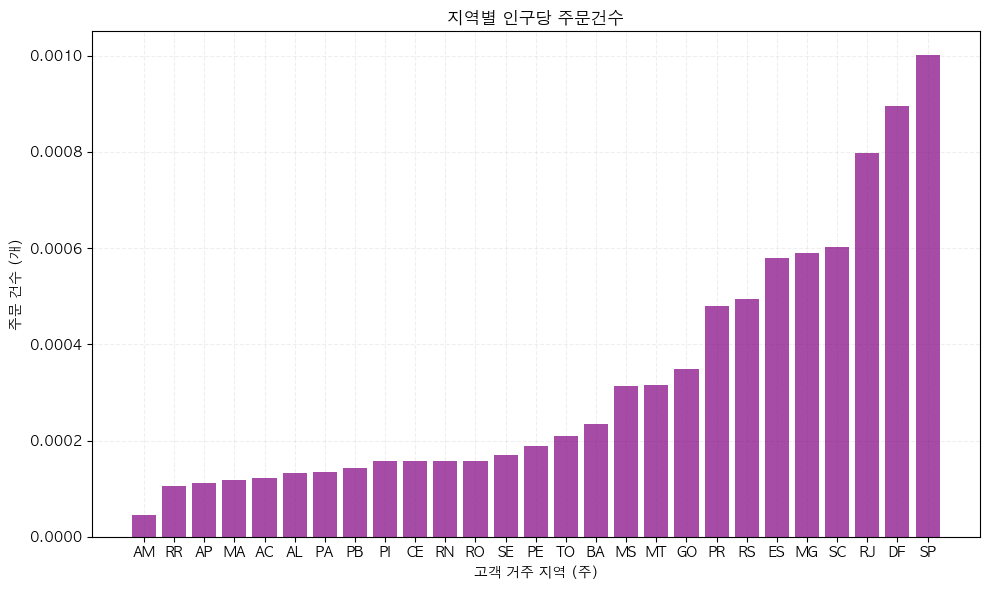

In [ ]:
# 지역별 인구당 주문건수
sorted_df_brazil_geo = df_brazil_geo.sort_values(by='state_pop_cnt')
plt.figure(figsize=(10, 6))
plt.bar(sorted_df_brazil_geo['state'], sorted_df_brazil_geo['state_pop_cnt'], color = 'purple', alpha=0.7)
plt.title('지역별 인구당 주문건수')
plt.xlabel('고객 거주 지역 (주)')
plt.ylabel('주문 건수 (개)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()

- 우측으로 갈수록 주별 인구당 주문건수가 늘어남
- 상파울루 주가 가장 높고, 아마주나스 주가 가장 낮다는 것을 알 수 있음

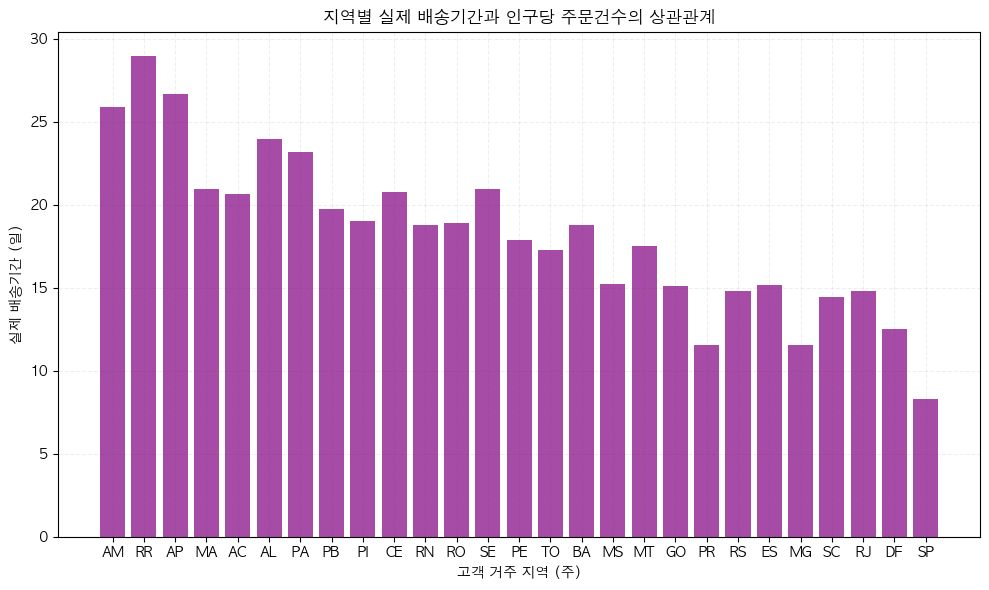

In [ ]:
# 지역별 실제 배송기간과 인당 주문건수의 상관관계
df_grap = reviews_region_join_new.groupby('state')[['real_dt', 'state_pop_cnt']].mean().sort_values(by='state_pop_cnt')
plt.figure(figsize=(10, 6))
plt.bar(df_grap.index, df_grap['real_dt'], color = 'purple', alpha=0.7)
plt.title('지역별 실제 배송기간과 인구당 주문건수의 상관관계')
plt.xlabel('고객 거주 지역 (주)')
plt.ylabel('실제 배송기간 (일)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

- 인당 배송주문건수가 높은 지역은 평균 배송일이 짧다는 것을 확인할 수 있다.

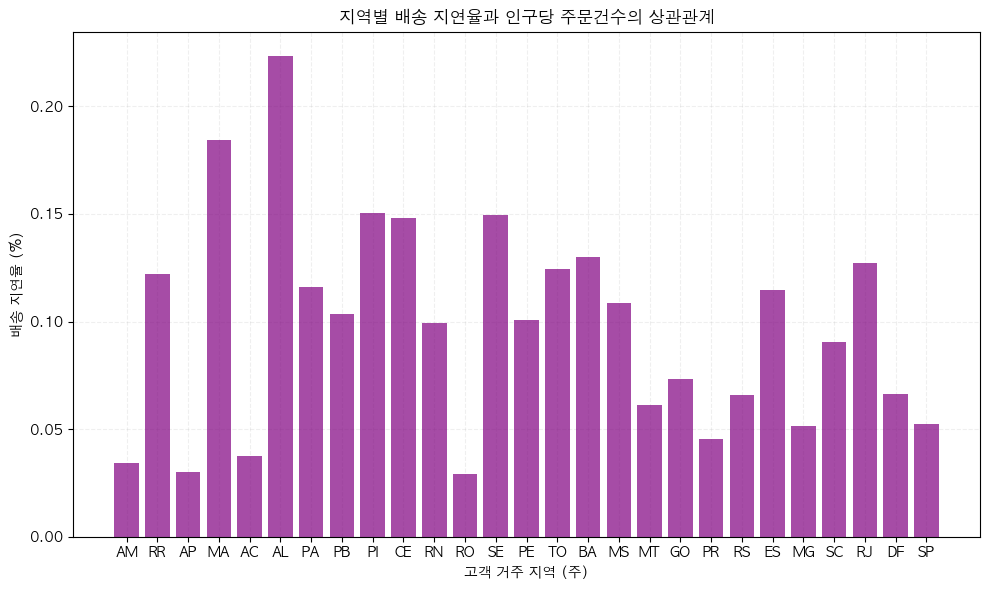

In [ ]:
# 지역별 배송 지연율과 인구당 주문건수의 상관관계
df_grap = reviews_region_join_new.groupby('state')[['est_dlv_diff_group', 'state_pop_cnt']].mean().sort_values(by='state_pop_cnt')
df_grap['est_dlv_diff_ratio'] = 1 - df_grap['est_dlv_diff_group'] # 배송 미지연 그룹(1) 제외
plt.figure(figsize=(10, 6))
plt.bar(df_grap.index, df_grap['est_dlv_diff_ratio'], color = 'purple', alpha=0.7)
plt.title('지역별 배송 지연율과 인구당 주문건수의 상관관계')
plt.xlabel('고객 거주 지역 (주)')
plt.ylabel('배송 지연율 (%)')
plt.gca().set_axisbelow(True)
plt.grid(linestyle="--", alpha=0.2)
plt.tight_layout()
plt.show()

- 배송 지연 자체는 고객 거주지역과 상관 없는 것으로 보인다.

# 통계적 결론

- 배송은 리뷰에 직간접적 영향을 주는 요인이라고 설명할 수 있습니다. 특히 배송의 지연은 리뷰에 부정적인 영향을 끼칠 가능성이 높습니다.
- 효과 크기가 낮다고 하더라도 1점 혹은 5점으로 편향된 리뷰가 나타날 수밖에 없는 이커머스 환경에서 1점의 증가는 실질적인 부정 의견의 증가로도 볼 수 있기 때문입니다.
- 문제는 기존 배송 예측 모델이 상당히 보수적으로 예측을 시행하고 있다는 데 있습니다. 기존 예측 모델은 10일 정도 느리게 도착할 것이라 예측하고 있습니다. 그러나 보수적인 모델에서도 지연이 발생하고, 그로 인해 불만족이 발생하고 있었습니다.
- 따라서 기존 모델의 정확도를 개선할 필요가 있음을 확인할 수 있습니다.

- 그러나 보수적 예측 자체가 가저오는 효용이 있다는 것 역시 확인할 수 있었습니다.
- 기존 배송 예측 모델은 보수적 예측을 통해 부정확한 예측에서 오는 지연을 방지하였고, 동시에 기존 예측보다 일찍 도착하는 결과를 통하여 고객의 만족을 유도한 것입니다.
- 따라서 정확한 예측 모델을 제안하되, 실제 출력에서 예상 시간 혹은 날짜를 더하는 등, 보수적 예측을 하도록하는 것이 더 좋을 것입니다.

# 머신러닝

## 회귀 모델링을 위한 데이터셋 만들기

In [ ]:
df_total = pd.merge(df_orders, df_order_items, on='order_id', how='inner')
df_total = pd.merge(df_total, df_order_payments, on='order_id', how='inner')
df_total = pd.merge(df_total, df_customers, on='customer_id', how='inner')
df_total = pd.merge(df_total, df_products, on='product_id', how='inner')
df_total = pd.merge(df_total, df_sellers, on='seller_id', how='inner')

In [ ]:
# 주문자 주소 별 위도, 경도 평균
geo_group_mean = df_geolocation.groupby(['geolocation_zip_code_prefix'])[['geolocation_lat','geolocation_lng']].mean().reset_index()

In [ ]:
df_total = pd.merge(df_total,
                    geo_group_mean.rename(columns={
                        'geolocation_lat': 'customer_lat',
                        'geolocation_lng': 'customer_lng'
                    }),
                    how='left',
                    left_on='customer_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix')
df_total.drop(columns=['geolocation_zip_code_prefix'], inplace=True)

In [ ]:
df_total = pd.merge(df_total,
                    geo_group_mean.rename(columns={
                        'geolocation_lat': 'seller_lat',
                        'geolocation_lng': 'seller_lng'
                    }),
                    how='left', # 마찬가지로 left merge
                    left_on='seller_zip_code_prefix',
                    right_on='geolocation_zip_code_prefix')
df_total.drop(columns=['geolocation_zip_code_prefix'], inplace=True)

In [ ]:
df_total['distance_customer_seller_km'] = df_total.apply(
    lambda row: haversine(
        (row['customer_lat'], row['customer_lng']), # 고객 위도 경도
        (row['seller_lat'], row['seller_lng']),     # 판매자 위도 경도
        unit=Unit.KILOMETERS
    )
    # 위도/경도 중 하나라도 NaN이면 거리도 NaN이 되도록 처리 (매우 중요!)
    if pd.notna(row['customer_lat']) and pd.notna(row['customer_lng']) and
       pd.notna(row['seller_lat']) and pd.notna(row['seller_lng'])
    else np.nan,
    axis=1
)

In [ ]:
df_total.dropna(inplace=True)

In [ ]:
# datetime 변환
df_total['order_delivered_customer_date'] = pd.to_datetime(df_total['order_delivered_customer_date'])
df_total['order_purchase_timestamp'] = pd.to_datetime(df_total['order_purchase_timestamp'])
df_total['order_approved_at'] = pd.to_datetime(df_total['order_approved_at'])
df_total['order_estimated_delivery_date'] = pd.to_datetime(df_total['order_estimated_delivery_date'])
df_total['shipping_limit_date'] = pd.to_datetime(df_total['shipping_limit_date'])
df_total['order_delivered_carrier_date'] = pd.to_datetime(df_total['order_delivered_carrier_date'])

In [ ]:
# 부피로 통일해서 불필요한 컬럼 제거
df_total['product_volume_cm3'] = df_total['product_length_cm'] * df_total['product_height_cm'] * df_total['product_width_cm']
df_total.drop(['product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1, inplace=True)

In [ ]:
# order_purchase에서 밤 늦은 시간, 공휴일은 구매 승인이 늦어질 가능성이 있음. -> 공휴일 여부, 시간 변수 추가

df_total['purchase_dayofweek'] = df_total['order_purchase_timestamp'].dt.dayofweek
df_total['purchase_hour'] = df_total['order_purchase_timestamp'].dt.hour
df_total['purchase_month'] = df_total['order_purchase_timestamp'].dt.month
df_total['is_weekend'] = (df_total['purchase_dayofweek'] >= 5).astype(int)

In [ ]:
# 구매 승인일과 택배사 도착일 기간이 짧으면 배송이 빠르거나 물류 시스템이 효율적일 수 있음
df_total['shipping_duration_days'] = (df_total['order_delivered_carrier_date'] - df_total['order_approved_at']).dt.days

In [ ]:
# 판매자는 limit date 전까지 택배사에 물건을 전달해야 됨
is_late = df_total['shipping_limit_date'] < df_total['order_delivered_carrier_date']
df_total['is_late'] = is_late.astype(int)

In [ ]:
# 예상 배송일을 구하는 것은 예상 도착일을 구하는 것과 동일
df_total['estimated_duration_days'] = (df_total['order_delivered_customer_date'] - df_total['order_purchase_timestamp']).dt.days

In [ ]:
df_total.drop(['order_id', 'customer_id', 'order_purchase_timestamp', 'product_id', 'seller_id', 'shipping_limit_date',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'price', 'customer_city',
       'product_category_name', 'product_description_lenght', 'product_photos_qty','seller_zip_code_prefix', 'seller_city', 'product_weight_g', 'product_name_lenght', 'order_item_id'], axis=1, inplace=True)

## 모델링

In [ ]:
# 머신러닝 모델링에 필요한 파이썬 라이브러리와 싸이킷런 패키지를 호출합니다.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
import shap

sns.set()

In [ ]:
df = pd.read_csv("regression_dataset.csv")

In [ ]:
# payment_sequential은 1이 95.6%를 차지해 학습에 유효하게 사용될 수 없기에 제거합니다.
# 파생변수인 구매자, 판매자 간 거리를 구했으니 위도와 경도는 제거합니다.
# 구매자, 배송자 거주지(state)는 거리 파생 변수가 있기에 제거 합니다.
# order_status와 is_late는 배송하는 회사 입장에서는 미리 아는 정보이기 때문에 현실적이지 않고, 데이터 누수가 발생하기에 제거합니다.

df.drop(['payment_sequential', 'customer_state', 'seller_state', 'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng', 'order_status', 'Unnamed: 0', 'is_late'], axis=1, inplace=True)

In [ ]:
# target 변수의 분포를 확인합니다.
df['estimated_duration_days'].value_counts().reset_index()

,estimated_duration_days,count
0,7,8937
1,6,7985
2,8,7909
3,9,7073
4,5,6850
...,...,...
141,109,1
142,189,1
143,173,1
144,133,1


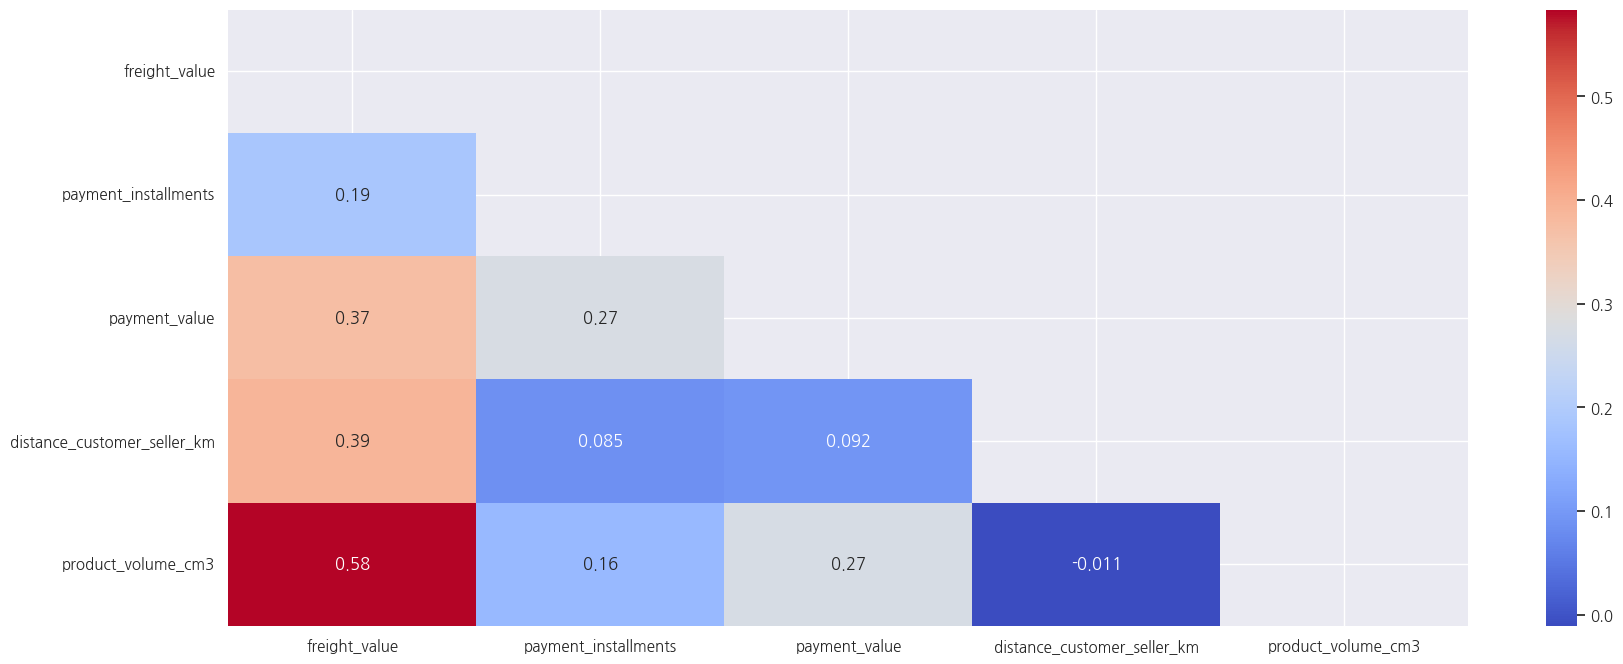

In [ ]:
# 수치형 변수 간 상관관계를 확인합니다.
tmp = df[['freight_value', 'payment_installments', 'payment_value', 'distance_customer_seller_km', 'product_volume_cm3']]
tmp_corr = tmp.corr()
mask = np.triu(np.ones_like(tmp_corr, dtype=bool)) # 마스크를 생성해서 중복되는 부분은 없애줍니다.

plt.figure(figsize=(20, 8))
sns.heatmap(
    data = tmp_corr,
    cmap = 'coolwarm',
    annot = True,
    mask = mask
)
plt.show()

## Linear Regression

In [ ]:
# 선형회귀 모델의 안정적인 학습을 위해 수치형 변수들을 표준 정규분포로 만듭니다.

num_cols = ['freight_value', 'payment_value', 'distance_customer_seller_km', 'product_volume_cm3']

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols)
    ]
)

In [ ]:
# 데이터 누수를 막기 위해 pipeline을 생성합니다.

pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)

In [ ]:
# 효율적인 학습과 우수한 성능을 위해 payment_type 카테고리 변수를 제거합니다.

X = df[["freight_value", "payment_value", "distance_customer_seller_km",
              "product_volume_cm3", 'purchase_dayofweek', 'purchase_hour',
              "purchase_month", "is_weekend", "shipping_duration_days"]] # 수치형 변수만 학습에 사용합니다.
y = df["estimated_duration_days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 데이터를 분할합니다.

In [ ]:
# 모델을 학습시킵니다.
model = pipeline.fit(X_train, y_train)

In [ ]:
# 학습한 모델로 예측값을 구합니다.
lr_pred = model.predict(X_test)

In [ ]:
# 회귀 모델의 성능을 확인할 수 있는 r2(설명력)와 mae(오차)를 구합니다.

print("r2 score: ", r2_score(y_test, lr_pred))
print("mae: ", mean_squared_error(y_test, lr_pred))
print("rmse: ", root_mean_squared_error(y_test, lr_pred))

## Lasso

In [ ]:
# 학습에 사용할 파이프라인을 구합니다.
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ]
)

In [ ]:
# 모델을 학습시킵니다.
model = pipeline.fit(X_train, y_train)

In [ ]:
# 학습한 모델로 예측값을 만듭니다.
lasso_pred = model.predict(X_test)

In [ ]:
# 회귀 모델의 성능을 확인할 수 있는 r2(설명력)와 mae(오차)를 구합니다.

print("r2 score: ", r2_score(y_test, lr_pred))
print("mae: ", mean_squared_error(y_test, lr_pred))
print("rmse: ", root_mean_squared_error(y_test, lr_pred))

### Ridge

In [ ]:
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ]
)

In [ ]:
model = pipeline.fit(X_train, y_train)

In [ ]:
ridge_pred = model.predict(X_test)

In [ ]:
# 회귀 모델의 성능을 확인할 수 있는 r2(설명력)와 mae(오차)를 구합니다.

print('r2 score: ',r2_score(y_test, ridge_pred))
print('mae: ', mean_squared_error(y_test, ridge_pred))
print("rmse: ", root_mean_squared_error(y_test, lr_pred))

### XGBoost

In [ ]:
xgb_pipeline = Pipeline(
    steps = [
        ('regressor', XGBRegressor(random_state=42))
    ]
)

In [ ]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__subsample': [0.8, 1.0]
}
# scoring으로 모델 성능 평가 기준을 지정합니다.
scoring = ['neg_mean_squared_error', 'r2']

In [ ]:
xgb_grid = GridSearchCV(
    estimator = xgb_pipeline,
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    verbose = 2,
    scoring = scoring,
    refit = 'r2' # r2를 기준으로 모델을 평가합니다.
)

In [ ]:
xgb_grid.fit(X_train, y_train)

In [ ]:
xgb_pred = xgb_grid.predict(X_test)

In [ ]:
print("r2 score: ", r2_score(y_test, xgb_pred))
print("mse score: ", mean_squared_error(y_test, xgb_pred))
print("rmse: ", root_mean_squared_error(y_test, lr_pred))

## Feature importance

In [ ]:
# feature importance
plot_importance(xgb_grid.best_estimator_.named_steps['regressor'])
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

## SHAP Value

In [ ]:
# SHAP explainer
explainer = shap.TreeExplainer(xgb_grid.best_estimator_.named_steps['regressor'])
shap_values = explainer.shap_values(X_test[:1000])  # 샘플 일부만

# Beeswarm plot (값의 영향 방향 표시)
shap.summary_plot(shap_values, X_test[:1000])